In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook

In [8]:
# simulation time
sim_time = 100
time_step = 2

In [9]:
# giu' su sinistra destra
colummella = [8,8,12,12]
# if in future we want to add lateral pin we already have everything set
epidermal_l, epidermal_r = [0,8,0,0], [0,8,0,0]
# if we want to add the last 5 cells to be longer this needs fix (grieneisen 2007 fig 1)
border_l, border_r = [8,0,0,12], [8,0,12,0]
vascular = [8,0,0,0]

P_out = np.zeros((22,12,4))

# 22 rows, 12 columns. The first is the upmost cell in the tip

# cinta esterna della radice (muraria)
P_out[0,:,:]=[0,0,0,0]
P_out[-1,:,:]=[0,0,0,0]
P_out[:,0,:]=[0,0,0,0]
P_out[:,-1,:]=[0,0,0,0]

# in futuro aggiungeremo un flusso di auxina dallo shoot

# defining colummellas
P_out[1:4,1:11] = colummella

# defining epidermal
P_out[4:21,1:3] = epidermal_l
P_out[4:21,9:11] = epidermal_r

# defining border
P_out[4:21,3] = border_l
P_out[4:21,8] = border_r

# defining vascular
P_out[4:21,4:8] = vascular

# defining QC in position [4,4:8] same PIN settings as vascular
#defining directions 0 is down, 1 is up, 2 is left, 3 is right

directions = [0, 1, 2, 3]

In [38]:
def update_2D(cells, counter, source=(4,4), source_val=10, D=0.5, T=0.5, P_out=P_out, decay=0.000005 ):
    """
    updates vector of cells following equation (1)
    
    WORKS ONLY FOR 1D MODELS
    
    cells : numpy array, set of cells to simulate
    source : int, index of QC cell
    source_val : float, amount of auxin produced at every step by the QC cell
    D : float, diffusion rate of auxin
    T : float, PIN1-mediated transport rate
    P_out : numpy matrix (lenght,width,4), amount of PIN1 that a cell outtakes to every neighbour (down, up, left, right)
    """
    # define neighbours
    v = np.array([[-1,0], [1,0], [0,-1], [0,1]])
    updated_cells = np.zeros((len(cells),12))
    cells_flux = np.zeros((2,len(cells),12))
    for i, value in enumerate(cells[1:20], 1):
        step = np.zeros(cells.shape[1])
        step_direction_flux = np.zeros((2,cells.shape[1]))
        for j in range(1,len(cells[i])-1):
            neighbours = [cells[k] for k in tuple(map(tuple, v + [i,j]))]
            
            diffusion_in = sum(neighbours)*(D/(value[j]+1))
            diffusion_out = -(1/2.5)*sum([1/(i) if i != 0 else 0 for i in neighbours])*D*value[j]
            aux_decay = -decay*value[j]

            transport_in = T*np.dot(P_out[i,j,:],neighbours)*(D/(value[j]+1))
            transport_out = -T*sum(P_out[i,j,:])*value[j]*sum([1/(i) if i != 0 else 0 for i in neighbours])
            
            
            
            
            #diagnostics
            
            if (P_out[i,j,:] == colummella).all():
                cell_type = 'colummella'
            elif (P_out[i,j,:] == epidermal_l).all():
                cell_type = 'epidermal'
            elif (P_out[i,j,:] == vascular).all():
                cell_type = 'vascular/QC'
            elif (P_out[i,j,:] == border_l).all():
                cell_type = 'border l'
            elif (P_out[i,j,:] == border_r).all():
                cell_type = 'border r'
            
            
            print('Total Diffusion/Transport ratio: '+ str((diffusion_in-diffusion_out)/(transport_in-transport_out)), ' Diffusion: ' + str((diffusion_in-diffusion_out)),  'Transport: ' + str(transport_in-transport_out), ' Value: '+str(value[j]),
                 'Cell type:'+ cell_type)
           


            print('')
            print('Out_Transport_Components:')
            print('Pin sum:' + str(sum(P_out[i,j,:])), ' Old auxin amount:' + str(value[j]), 'Inverse of Neigh Sum: ' + str(sum([1/(i) if i != 0 else 0 for i in neighbours])),  'Transport out: '+ str(transport_out))
            
            
            
            transport_out_down = -T*P_out[i,j,0]*value[j] ##divide the output of the transport depending on the direction
            transport_out_up =  -T*P_out[i,j,1]*value[j]
            transport_out_left =  -T*P_out[i,j,2]*value[j]
            transport_out_right = -T*P_out[i,j,3]*value[j]
            
            x_coord = (transport_out_left-transport_out_right)
            y_coord = (transport_out_up-transport_out_down)
            
            # last piece is the basal auxin production of each cell (a.u./(micrometers^2*sec))
            step[j] = value[j] + transport_in + transport_out + diffusion_in + diffusion_out + aux_decay + 16*24*0.0005
            step_direction_flux[:,j] = (x_coord, y_coord)
            
            
            print('')
            print(f'Step: {step[j]}')
            print('')
            print('Next cell')
            print('')
            
            

            #if step[j] <= 0:
            #    step[j] = 0

        updated_cells[i,:] = [0] + step + [0]
        cells_flux[:,i,:] = [0] + step_direction_flux + [0]
    updated_cells[source[0], source[1]:source[1]+4] += source_val*16*24
    print('')
    print('')
    print('')
    print('')
    print('')
    print('')
    print('')
    
    print(f'Iteration n: {counter}')
    return updated_cells,cells_flux

In [39]:
%matplotlib notebook
# number of cells within one single tissue
cells_a = np.ones((22,12))*20
cells_a[0,:]=0
cells_a[-1,:]=0
cells_a[:,0]=0
cells_a[:,-1]=0
# QC cell starts with an initial amount of auxin
#cells_a[3][1] = 10
cells_a[4,4:8] = 40
# fig= plt.figure(figsize=(12,5)) #common canvas for any figure
# plt.ion()
# plt.title('Time: Beginning')
# plt.axis('off')
# plt.imshow(cells_a.T, cmap="jet")
cells_out = cells_a

times = np.arange(0, sim_time, time_step)   
roun = 0
for t in times:
    roun += 1 
    cells_out, cells_fluxes = update_2D(cells_out, T=2, D=10, counter=roun)
    #print(cells_fluxes)
#     plt.imshow(cells_out.T, cmap="jet")
    
# ### normalized arrows

#     U = cells_fluxes[1,:,:].T
#     V = cells_fluxes[0,:,:].T
#     U_norm = U / np.sqrt(U**2 + V**2);
#     V_norm = V / np.sqrt(U**2 + V**2);
    
#     plt.quiver(U_norm, V_norm, pivot='mid')

#     plt.title(f"Timestep: {str(t)}")
#     plt.axis('off')
#     fig.canvas.draw()
#     fig.canvas.flush_events()
#     if t != times[-1]:
#         plt.clf() ##to avoid the clearance of the plot


Total Diffusion/Transport ratio: 0.05  Diffusion: 27.04761904761905 Transport: 540.952380952381  Value: 20.0 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.1 Transport out: -160.0

Step: 252.19189999999995

Next cell

Total Diffusion/Transport ratio: 0.04775784753363228  Diffusion: 40.57142857142857 Transport: 849.5238095238095  Value: 20.0 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.15000000000000002 Transport out: -240.00000000000003

Step: 406.2871380952381

Next cell

Total Diffusion/Transport ratio: 0.04775784753363228  Diffusion: 40.57142857142857 Transport: 849.5238095238095  Value: 20.0 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.15000000000000002 Transport out: -240.00000000000003

Step: 406.2871380952381

Next cell

Total Diffusion/Transport ratio: 0.04775784753363228  Diffusion: 40.5714285

Pin sum:8.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.2 Transport out: -64.0

Step: 130.66809047619049

Next cell

Total Diffusion/Transport ratio: 0.25000000000000006  Diffusion: 54.0952380952381 Transport: 216.38095238095238  Value: 20.0 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.2 Transport out: -64.0

Step: 130.66809047619049

Next cell

Total Diffusion/Transport ratio: 0.25000000000000006  Diffusion: 54.0952380952381 Transport: 216.38095238095238  Value: 20.0 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.2 Transport out: -64.0

Step: 130.66809047619049

Next cell

Total Diffusion/Transport ratio: 0.1  Diffusion: 54.0952380952381 Transport: 540.952380952381  Value: 20.0 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.2 Transport out: -160.0

Step: 263.239519047619

Next cell

Total Diffusion/Tra

Total Diffusion/Transport ratio: 0.1  Diffusion: 54.0952380952381 Transport: 540.952380952381  Value: 20.0 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.2 Transport out: -160.0

Step: 263.239519047619

Next cell

Total Diffusion/Transport ratio: 0.25000000000000006  Diffusion: 54.0952380952381 Transport: 216.38095238095238  Value: 20.0 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.2 Transport out: -64.0

Step: 130.66809047619049

Next cell

Total Diffusion/Transport ratio: 0.20247148288973382  Diffusion: 40.57142857142857 Transport: 200.38095238095238  Value: 20.0 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.15000000000000002 Transport out: -48.00000000000001

Step: 141.14428095238097

Next cell

Total Diffusion/Transport ratio: 0.20247148288973382  Diffusion: 40.57142857142857 Transport: 200.38095238095238 

Step: 271.76149474438574

Next cell

Total Diffusion/Transport ratio: 0.10386494166773418  Diffusion: 53.930965487037554 Transport: 519.2412821986045  Value: 263.239519047619 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:263.239519047619 Inverse of Neigh Sum: 0.022903599088461873 Transport out: -241.16529634024755

Step: 306.0387985871213

Next cell

Total Diffusion/Transport ratio: 0.29689027539684815  Diffusion: 63.75035214734048 Transport: 214.72697973056367  Value: 130.66809047619049 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:130.66809047619049 Inverse of Neigh Sum: 0.02675775521184228 Transport out: -55.942156463372235

Step: 269.4813778552117

Next cell

Total Diffusion/Transport ratio: 0.25  Diffusion: 55.69620581679786 Transport: 222.78482326719143  Value: 130.66809047619049 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:130.66809047619049 Inverse of Neigh Sum: 0.03061191133522269


Total Diffusion/Transport ratio: 0.25  Diffusion: 55.69620581679786 Transport: 222.78482326719143  Value: 130.66809047619049 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:130.66809047619049 Inverse of Neigh Sum: 0.030611911335222692 Transport out: -64.0

Step: 249.3404662197274

Next cell

Total Diffusion/Transport ratio: 0.25  Diffusion: 55.69620581679786 Transport: 222.78482326719143  Value: 130.66809047619049 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:130.66809047619049 Inverse of Neigh Sum: 0.030611911335222692 Transport out: -64.0

Step: 249.3404662197274

Next cell

Total Diffusion/Transport ratio: 0.29689027539684815  Diffusion: 63.75035214734048 Transport: 214.72697973056367  Value: 130.66809047619049 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:130.66809047619049 Inverse of Neigh Sum: 0.026757755211842284 Transport out: -55.94215646337224

Step: 269.4813778552117

Next cell


Total Diffusion/Transport ratio: 0.13491174151556073  Diffusion: 81.74362251190362 Transport: 605.9044349559101  Value: 2404.920251051109 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2404.920251051109 Inverse of Neigh Sum: 0.0030427277826022034 Transport out: -117.08028260505401

Step: 2800.047577405033

Next cell

Total Diffusion/Transport ratio: 0.13491174151556073  Diffusion: 81.74362251190362 Transport: 605.9044349559101  Value: 2404.920251051109 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2404.920251051109 Inverse of Neigh Sum: 0.0030427277826022034 Transport out: -117.08028260505401

Step: 2800.047577405033

Next cell

Total Diffusion/Transport ratio: 0.13116149180166248  Diffusion: 83.03346959060273 Transport: 633.0628635740348  Value: 2386.6943923068184 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2386.6943923068184 Inverse of Neigh Sum: 0.003955666760213901 Transport out: -15


Step: 394.258615680336

Next cell

Total Diffusion/Transport ratio: 0.20264569972827187  Diffusion: 41.98066649954615 Transport: 207.16287863911316  Value: 267.6584130900356 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:267.6584130900356 Inverse of Neigh Sum: 0.011151907640920425 Transport out: -47.758430433526456

Step: 397.59654385281334

Next cell

Total Diffusion/Transport ratio: 0.20264569972827187  Diffusion: 41.98066649954615 Transport: 207.16287863911316  Value: 267.6584130900356 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:267.6584130900356 Inverse of Neigh Sum: 0.011151907640920427 Transport out: -47.75843043352646

Step: 397.5965438528133

Next cell

Total Diffusion/Transport ratio: 0.25498610059643156  Diffusion: 56.57290672176539 Transport: 221.86662955132508  Value: 271.76149474438574 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:271.76149474438574 Inverse of Neigh Sum: 0.014363


Next cell

Total Diffusion/Transport ratio: 0.05085676224772738  Diffusion: 59.26510297916471 Transport: 1165.3337798123998  Value: 1634.7576352917536 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:1634.7576352917536 Inverse of Neigh Sum: 0.0024042949994039185 Transport out: -314.435168621547

Step: 2199.226490189893

Next cell

Total Diffusion/Transport ratio: 0.05019946978914348  Diffusion: 56.26093351928846 Transport: 1120.7475647771855  Value: 1464.8673256173927 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:1464.8673256173927 Inverse of Neigh Sum: 0.002823029858056929 Transport out: -330.8291358647921

Step: 1947.3193142611754

Next cell

Total Diffusion/Transport ratio: 0.05023939119535361  Diffusion: 58.62779907718731 Transport: 1166.9687407081776  Value: 1194.49092561243 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:1194.49092561243 Inverse of Neigh Sum: 0.003106792072604934 Transp

Total Diffusion/Transport ratio: 0.20157917610786633  Diffusion: 41.874859267410116 Transport: 207.73405307005822  Value: 397.5965438528133 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:397.5965438528133 Inverse of Neigh Sum: 0.007566631018928354 Transport out: -48.135461467766476

Step: 527.0568145381461

Next cell

Total Diffusion/Transport ratio: 0.2656189166817195  Diffusion: 58.2886197641551 Transport: 219.44453539805681  Value: 394.2586156803359 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:394.2586156803359 Inverse of Neigh Sum: 0.009487638836232286 Transport out: -59.849333658366945

Step: 522.558465403552

Next cell

Total Diffusion/Transport ratio: 0.10210975301329692  Diffusion: 53.57363448982778 Transport: 524.6671636043554  Value: 526.3950212963395 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:526.3950212963395 Inverse of Neigh Sum: 0.008897880066526717 Transport out: -187.35199068


Out_Transport_Components:
Pin sum:8.0  Old auxin amount:394.2586156803359 Inverse of Neigh Sum: 0.009487638836232286 Transport out: -59.849333658366945

Step: 522.558465403552

Next cell

Total Diffusion/Transport ratio: 0.10210975301329692  Diffusion: 53.57363448982778 Transport: 524.6671636043554  Value: 526.3950212963395 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:526.3950212963395 Inverse of Neigh Sum: 0.008897880066526717 Transport out: -187.35199068446423

Step: 692.6508079095948

Next cell

Total Diffusion/Transport ratio: 0.2635497970941963  Diffusion: 58.05641643501015 Transport: 220.28632567779968  Value: 390.3130808260421 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:390.3130808260421 Inverse of Neigh Sum: 0.009718993614208622 Transport out: -60.69520544144635

Step: 517.107857769832

Next cell

Total Diffusion/Transport ratio: 0.252326399785814  Diffusion: 56.213156762692165 Transport: 222.7795300468299  Val

Next cell

Total Diffusion/Transport ratio: 0.2867643346368774  Diffusion: 53.68792583434944 Transport: 187.2196760532761  Value: 567.9637449928107 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:567.9637449928107 Inverse of Neigh Sum: 0.004118106702277313 Transport out: -37.42296487848667

Step: 715.5030948654945

Next cell

Total Diffusion/Transport ratio: 0.21036740464416867  Diffusion: 42.88829304116392 Transport: 203.87328119443418  Value: 532.6806111100913 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:532.6806111100913 Inverse of Neigh Sum: 0.005373801703452736 Transport out: -45.800319606074446

Step: 665.1307229274477

Next cell

Total Diffusion/Transport ratio: 0.3945771856385488  Diffusion: 79.63802481973998 Transport: 201.83129617811238  Value: 582.5797679368487 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:582.5797679368487 Inverse of Neigh Sum: 0.005667661878058469 Transport out: -52

Total Diffusion/Transport ratio: 0.10207670628047295  Diffusion: 53.619370629244564 Transport: 525.2850780854577  Value: 692.6508079095948 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:692.6508079095948 Inverse of Neigh Sum: 0.006734951835805404 Transport out: -186.5987932121129

Step: 861.2264483036092

Next cell

Total Diffusion/Transport ratio: 0.2631879065791372  Diffusion: 58.01877628637932 Transport: 220.44620910016556  Value: 517.107857769832 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:517.107857769832 Inverse of Neigh Sum: 0.007343127767569699 Transport out: -60.75502510749018

Step: 643.8746948483627

Next cell

Total Diffusion/Transport ratio: 0.2522665683994371  Diffusion: 56.23137972947559 Transport: 222.90460478472605  Value: 492.1904680872008 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:492.1904680872008 Inverse of Neigh Sum: 0.008029033874784973 Transport out: -63.22902305

Pin sum:8.0  Old auxin amount:517.1916675543483 Inverse of Neigh Sum: 0.007334643559518582 Transport out: -60.694664535426824

Step: 644.0497121230055

Next cell

Total Diffusion/Transport ratio: 0.2524174457500542  Diffusion: 56.246842830611605 Transport: 222.8326281627447  Value: 492.2855348113518 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:492.2855348113518 Inverse of Neigh Sum: 0.008022252189529767 Transport out: -63.187819352227194

Step: 613.5849959964662

Next cell

Total Diffusion/Transport ratio: 0.2524174457500542  Diffusion: 56.246842830611605 Transport: 222.8326281627447  Value: 492.2855348113518 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:492.2855348113518 Inverse of Neigh Sum: 0.008022252189529767 Transport out: -63.187819352227194

Step: 613.5849959964662

Next cell

Total Diffusion/Transport ratio: 0.2634110796606331  Diffusion: 58.04527100810293 Transport: 220.36002085745912  Value: 517.1916675543483


Step: 3321.6303761896675

Next cell

Total Diffusion/Transport ratio: 0.05080332933061741  Diffusion: 59.60072612417594 Transport: 1173.1657532975235  Value: 2851.1255844120346 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:2851.1255844120346 Inverse of Neigh Sum: 0.0013655008441811835 Transport out: -311.4571513904963

Step: 3430.0097902857697

Next cell

Total Diffusion/Transport ratio: 0.05080332933061741  Diffusion: 59.60072612417594 Transport: 1173.1657532975235  Value: 2851.1255844120346 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:2851.1255844120346 Inverse of Neigh Sum: 0.0013655008441811833 Transport out: -311.4571513904962

Step: 3430.0097902857697

Next cell

Total Diffusion/Transport ratio: 0.05081588084406128  Diffusion: 59.21694777397282 Transport: 1165.3236506062326  Value: 2755.536721804816 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:2755.536721804816 Inverse of Neigh S

Total Diffusion/Transport ratio: 0.09399764254806305  Diffusion: 54.871871126726276 Transport: 583.7579500854938  Value: 970.7380053835404 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:970.7380053835404 Inverse of Neigh Sum: 0.004766860111122612 Transport out: -185.09489104854106

Step: 1202.3462125989433

Next cell

Total Diffusion/Transport ratio: 0.2736411140820569  Diffusion: 59.67848498993239 Transport: 218.0903450496718  Value: 650.7825862569634 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:650.7825862569634 Inverse of Neigh Sum: 0.0056024687537501155 Transport out: -58.335825679829235

Step: 782.9005981840633

Next cell

Total Diffusion/Transport ratio: 0.2015463314722856  Diffusion: 41.90151637168427 Transport: 207.90016898643523  Value: 656.6290162978217 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:656.6290162978217 Inverse of Neigh Sum: 0.004582445534169791 Transport out: -48.1434672

Total Diffusion/Transport ratio: 0.2631452703663524  Diffusion: 58.0255032293924 Transport: 220.50749059106766  Value: 643.8746948483627 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:643.8746948483627 Inverse of Neigh Sum: 0.005897459677852861 Transport out: -60.75560080732855

Step: 770.7074672770271

Next cell

Total Diffusion/Transport ratio: 0.10207232986836988  Diffusion: 53.63614473420223 Transport: 525.4719354733077  Value: 861.2264483036092 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:861.2264483036092 Inverse of Neigh Sum: 0.005411919454275093 Transport out: -186.43552680442178

Step: 1030.3640634091498

Next cell

Total Diffusion/Transport ratio: 0.27005991416607616  Diffusion: 58.05009938748239 Transport: 214.9526691761587  Value: 650.7825862569634 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:650.7825862569634 Inverse of Neigh Sum: 0.005810001218408523 Transport out: -60.49676190

Total Diffusion/Transport ratio: 0.04952717023406664  Diffusion: 29.796668019991795 Transport: 601.6226624531948  Value: 1994.4261548211434 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:1994.4261548211434 Inverse of Neigh Sum: 0.0008851847389788548 Transport out: -141.2348476214364

Step: 2329.434333158539

Next cell

Total Diffusion/Transport ratio: 0.04811967021178282  Diffusion: 42.14834831430741 Transport: 875.9068407743734  Value: 2410.2005388901134 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:2410.2005388901134 Inverse of Neigh Sum: 0.001267339770477489 Transport out: -244.36343982093732

Step: 2815.2724533521314

Next cell

Total Diffusion/Transport ratio: 0.048160572039442205  Diffusion: 42.78528976785486 Transport: 888.3883217336968  Value: 2606.7647481272243 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:2606.7647481272243 Inverse of Neigh Sum: 0.001117180936284791 Transport out


Step: 920.1929687744254

Next cell

Total Diffusion/Transport ratio: 0.32305286706492126  Diffusion: 67.59289280184382 Transport: 209.23167596670868  Value: 825.112637004103 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:825.112637004103 Inverse of Neigh Sum: 0.004164129692712885 Transport out: -54.97401650530262

Step: 964.690038946214

Next cell

Total Diffusion/Transport ratio: 0.08251372725114188  Diffusion: 58.616588980591054 Transport: 710.3859070889308  Value: 1983.6548832037968 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:1983.6548832037968 Inverse of Neigh Sum: 0.0026918917293924493 Transport out: -213.5913669626098

Step: 2282.9384536811613

Next cell

Total Diffusion/Transport ratio: 0.15435769749898542  Diffusion: 63.911002493045956 Transport: 414.0448032626688  Value: 2151.5974031931705 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2151.5974031931705 Inverse of Neigh Sum: 0.0019

Pin sum:20.0  Old auxin amount:1030.3613266580473 Inverse of Neigh Sum: 0.004522191442629442 Transport out: -186.37964696917362

Step: 1199.7276046716684

Next cell

Total Diffusion/Transport ratio: 0.2631434091203214  Diffusion: 58.03461696284629 Transport: 220.54368436151927  Value: 770.7072410202694 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:770.7072410202694 Inverse of Neigh Sum: 0.004926564008277626 Transport out: -60.75101687247054

Step: 897.5961466272535

Next cell

Total Diffusion/Transport ratio: 0.2521913796789337  Diffusion: 56.24775551558569 Transport: 223.03599586629423  Value: 734.7473885555286 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:734.7473885555286 Inverse of Neigh Sum: 0.005380544966456627 Transport out: -63.25346180975361

Step: 856.0858116760817

Next cell

Total Diffusion/Transport ratio: 0.2521913796789337  Diffusion: 56.24775551558568 Transport: 223.0359958662942  Value: 734.7473885555286

Total Diffusion/Transport ratio: 0.20713277272873376  Diffusion: 42.01940093594446 Transport: 202.86215639557008  Value: 759.9414324044272 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:759.9414324044272 Inverse of Neigh Sum: 0.003939945978443785 Transport out: -47.90605104727412

Step: 885.2460624105945

Next cell

Total Diffusion/Transport ratio: 0.20919777312171792  Diffusion: 42.485990227782224 Transport: 203.09006923827303  Value: 789.1931489019663 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:789.1931489019663 Inverse of Neigh Sum: 0.0037291628314710112 Transport out: -47.08847612378848

Step: 917.2360720928059

Next cell

Total Diffusion/Transport ratio: 0.07413025027828161  Diffusion: 46.82842623701711 Transport: 631.7046827877326  Value: 896.6014390898649 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:896.6014390898649 Inverse of Neigh Sum: 0.006946291333291362 Transport out: -249.12

Pin sum:8.0  Old auxin amount:2465.0521479893114 Inverse of Neigh Sum: 0.0016578985722890236 Transport out: -65.38890298831153

Step: 2781.2080692401364

Next cell

Total Diffusion/Transport ratio: 0.08280505427579637  Diffusion: 58.51623602830339 Transport: 706.6746896077752  Value: 2282.9384536811613 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:2282.9384536811613 Inverse of Neigh Sum: 0.0023155597829341837 Transport out: -211.45121881032202

Step: 2583.117283242263

Next cell

Total Diffusion/Transport ratio: 0.32087906411885525  Diffusion: 67.2287610286245 Transport: 209.51432656797647  Value: 964.6900389462141 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:964.6900389462141 Inverse of Neigh Sum: 0.0035726423558889056 Transport out: -55.143879895093804

Step: 1103.7606033548861

Next cell

Total Diffusion/Transport ratio: 0.20500214606740463  Diffusion: 42.31599887467933 Transport: 206.4173458006915  Value: 920.1929687744

Pin sum:8.0  Old auxin amount:905.8156982691673 Inverse of Neigh Sum: 0.004150928677283524 Transport out: -60.15962173246539

Step: 1031.2524065624516

Next cell

Total Diffusion/Transport ratio: 0.20355841473851397  Diffusion: 41.8173961330328 Transport: 205.4319207916331  Value: 914.4124673151429 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:914.4124673151429 Inverse of Neigh Sum: 0.0033088936407160673 Transport out: -48.41109756944904

Step: 1040.8214682538496

Next cell

Total Diffusion/Transport ratio: 0.21196829588726743  Diffusion: 41.57268781570846 Transport: 196.12691436561983  Value: 898.367620035465 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:898.367620035465 Inverse of Neigh Sum: 0.0034265646383913216 Transport out: -49.25303550542873

Step: 1013.1221416151213

Next cell

Total Diffusion/Transport ratio: 0.2770087611390008  Diffusion: 58.14055384726337 Transport: 209.8870577529817  Value: 891.5007615888036 Cell

Total Diffusion/Transport ratio: 0.0513409535881355  Diffusion: 42.396932515509945 Transport: 825.7916838791937  Value: 2835.2975232981744 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:2835.2975232981744 Inverse of Neigh Sum: 0.0010785250166777736 Transport out: -244.6351446881291

Step: 3189.9301593601904

Next cell

Total Diffusion/Transport ratio: 0.05079552632532621  Diffusion: 44.50282989247417 Transport: 876.1171132955747  Value: 2398.8501471802983 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:2398.8501471802983 Inverse of Neigh Sum: 0.0015449389596947634 Transport out: -296.48616406786886

Step: 2697.0291515750873

Next cell

Total Diffusion/Transport ratio: 0.04880354320399606  Diffusion: 58.83560188632526 Transport: 1205.5600479742989  Value: 3143.041806452763 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:3143.041806452763 Inverse of Neigh Sum: 0.0016542412058770325 Transport out

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:1980.8476861895167 Inverse of Neigh Sum: 0.002489856317756784 Transport out: -197.28104503891504

Step: 2225.131272649647

Next cell

Total Diffusion/Transport ratio: 0.1923641817594382  Diffusion: 59.6599673141569 Transport: 310.1407276993225  Value: 1790.2824624164843 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1790.2824624164843 Inverse of Neigh Sum: 0.0021546567740669074 Transport out: -61.71910776222178

Step: 2005.9684366120973

Next cell

Total Diffusion/Transport ratio: 0.1875030204193618  Diffusion: 59.03451420978869 Transport: 314.8456706337554  Value: 1799.3947821064937 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1799.3947821064937 Inverse of Neigh Sum: 0.00220951100409108 Transport out: -63.6125211482939

Step: 2014.4266671053924

Next cell

Total Diffusion/Transport ratio: 0.1875030204193618  Diffusion: 59.03451420978869 Transport: 314.845670633755


Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1045.6278935732525 Inverse of Neigh Sum: 0.0028785473143911177 Transport out: -48.15822983836364

Step: 1175.2893629460189

Next cell

Total Diffusion/Transport ratio: 0.20200248428105402  Diffusion: 41.890874539266136 Transport: 207.3780166039033  Value: 1045.3133078324313 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1045.3133078324313 Inverse of Neigh Sum: 0.0028829763670389953 Transport out: -48.21781700211612

Step: 1174.2244299037711

Next cell

Total Diffusion/Transport ratio: 0.26569052361095025  Diffusion: 58.24332029486099 Transport: 219.21489522203095  Value: 1035.3749987916167 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1035.3749987916167 Inverse of Neigh Sum: 0.003622222803667876 Transport out: -60.0057428955295

Step: 1163.0056801946907

Next cell

Total Diffusion/Transport ratio: 0.10206270932994811  Diffusion: 53.65367509589923 Transport: 525.69322770


Out_Transport_Components:
Pin sum:40.0  Old auxin amount:4508.6573622017 Inverse of Neigh Sum: 0.0008970352280496507 Transport out: -323.5539588080271

Step: 5012.687017036313

Next cell

Total Diffusion/Transport ratio: 0.050807280349754375  Diffusion: 59.060701649344026 Transport: 1162.4456424900836  Value: 5007.4699871540915 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:5007.4699871540915 Inverse of Neigh Sum: 0.0007852460495735938 Transport out: -314.56768206168675

Step: 5568.551161614042

Next cell

Total Diffusion/Transport ratio: 0.05078842174649779  Diffusion: 59.542806848619136 Transport: 1172.3697016185588  Value: 5167.761726631973 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:5167.761726631973 Inverse of Neigh Sum: 0.0007522197365810246 Transport out: -310.9833891776483

Step: 5746.775279017457

Next cell

Total Diffusion/Transport ratio: 0.05078842174649778  Diffusion: 59.542806848619136 Transport: 1172.369

Total Diffusion/Transport ratio: 0.18827049232385137  Diffusion: 58.99451865568544 Transport: 313.34978693425137  Value: 2014.4266671053924 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2014.4266671053924 Inverse of Neigh Sum: 0.0019682945915961625 Transport out: -63.439761824490034

Step: 2228.3534960007682

Next cell

Total Diffusion/Transport ratio: 0.1882704923238514  Diffusion: 58.99451865568545 Transport: 313.34978693425137  Value: 2014.4266671053924 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2014.4266671053924 Inverse of Neigh Sum: 0.0019682945915961625 Transport out: -63.439761824490034

Step: 2228.3534960007682

Next cell

Total Diffusion/Transport ratio: 0.19318948836018027  Diffusion: 59.62947278339223 Transport: 308.6579569599549  Value: 2005.9684366120973 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2005.9684366120973 Inverse of Neigh Sum: 0.0019178591951890982 Transport 

Total Diffusion/Transport ratio: 0.10137377181120245  Diffusion: 53.55767422893106 Transport: 528.3188468973648  Value: 1535.496424372698 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:1535.496424372698 Inverse of Neigh Sum: 0.003065330941910513 Transport out: -188.27218803290347

Step: 1703.3584543444842

Next cell

Total Diffusion/Transport ratio: 0.28133401593454127  Diffusion: 58.274312123991876 Transport: 207.13567796064416  Value: 1123.1012461424095 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1123.1012461424095 Inverse of Neigh Sum: 0.0033773275431129854 Transport out: -60.689292356820424

Step: 1236.9743898287638

Next cell

Total Diffusion/Transport ratio: 0.21679356472216718  Diffusion: 41.580865314199976 Transport: 191.79935238155306  Value: 1125.152573624044 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1125.152573624044 Inverse of Neigh Sum: 0.0027463296700456974 Transport out: -49

Pin sum:8.0  Old auxin amount:36947.719783956396 Inverse of Neigh Sum: 0.0002912496743457666 Transport out: -172.176181678335

Step: 36797.31715232476

Next cell

Total Diffusion/Transport ratio: 0.31733384218760496  Diffusion: 67.45683672429945 Transport: 212.5737244388185  Value: 36947.719783956396 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:36947.719783956396 Inverse of Neigh Sum: 0.0002912496743457666 Transport out: -172.176181678335

Step: 36797.31715232476

Next cell

Total Diffusion/Transport ratio: 0.27754288779464037  Diffusion: 73.78052249312114 Transport: 265.834671820929  Value: 36195.29037154101 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:36195.29037154101 Inverse of Neigh Sum: 0.00039182798126128493 Transport out: -226.91724091915097

Step: 35967.623487105324

Next cell

Total Diffusion/Transport ratio: 0.06160779874528746  Diffusion: 91.3550769806762 Transport: 1482.849230799115  Value: 8394.7479777457


Out_Transport_Components:
Pin sum:20.0  Old auxin amount:1759.6278298985928 Inverse of Neigh Sum: 0.00263431526972209 Transport out: -185.41657845319233

Step: 1944.00145807637

Next cell

Total Diffusion/Transport ratio: 0.26709272961045555  Diffusion: 58.57677460554382 Transport: 219.31250128363953  Value: 1293.8075716654075 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1293.8075716654075 Inverse of Neigh Sum: 0.002878258663745491 Transport out: -59.58260563784759

Step: 1422.9258644221136

Next cell

Total Diffusion/Transport ratio: 0.2015576042365573  Diffusion: 41.92616061248533 Transport: 208.01081046428226  Value: 1305.1108423893875 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1305.1108423893875 Inverse of Neigh Sum: 0.002305256650068596 Transport out: -48.13784717591621

Step: 1434.8886699721525

Next cell

Total Diffusion/Transport ratio: 0.2015288118005951  Diffusion: 41.91938236250843 Transport: 208.006894835394

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:1420.4712006394461 Inverse of Neigh Sum: 0.004564891813402992 Transport out: -259.37189419894906

Step: 1551.4458305216658

Next cell

Total Diffusion/Transport ratio: 0.20714008021342  Diffusion: 42.25669842482519 Transport: 204.00058926928762  Value: 1300.6897403452613 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1300.6897403452613 Inverse of Neigh Sum: 0.0022823399523981217 Transport out: -47.49785856102926

Step: 1428.3878781880992

Next cell

Total Diffusion/Transport ratio: 0.20675008547959217  Diffusion: 41.99303961891547 Transport: 203.11014392814124  Value: 1261.1155068563896 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1261.1155068563896 Inverse of Neigh Sum: 0.0023790967115170777 Transport out: -48.005052083283665

Step: 1386.3917546177026

Next cell

Total Diffusion/Transport ratio: 0.20675008547959217  Diffusion: 41.99303961891547 Transport: 203.1101

Step: 1566.290155486038

Next cell

Total Diffusion/Transport ratio: 0.27929862458560994  Diffusion: 60.41723466160542 Transport: 216.3176949089718  Value: 1442.8572308676896 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1442.8572308676896 Inverse of Neigh Sum: 0.0025120655537367808 Transport out: -57.99283117796418

Step: 1574.794868207202

Next cell

Total Diffusion/Transport ratio: 0.0942048545090738  Diffusion: 54.364881317687434 Transport: 577.092142448466  Value: 2294.690558611727 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:2294.690558611727 Inverse of Neigh Sum: 0.0020755693041825058 Transport out: -190.51157144207627

Step: 2507.2026517525196

Next cell

Total Diffusion/Transport ratio: 0.21992981385129107  Diffusion: 58.564932086648525 Transport: 266.28919045167794  Value: 1891.2822946080282 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1891.2822946080282 Inverse of Neigh Sum: 0.00

Step: 1450.6368728695343

Next cell

Total Diffusion/Transport ratio: 0.24786342669288944  Diffusion: 41.99288784334574 Transport: 169.41945975505394  Value: 1172.706433449853 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1172.706433449853 Inverse of Neigh Sum: 0.00271260147369929 Transport out: -50.89736319348336

Step: 1257.061509532377

Next cell

Total Diffusion/Transport ratio: 0.3107162318300694  Diffusion: 59.21375701990081 Transport: 190.57181747841483  Value: 1222.3349032506442 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1222.3349032506442 Inverse of Neigh Sum: 0.0031470410776748077 Transport out: -61.547810419287025

Step: 1318.436840026226

Next cell

Total Diffusion/Transport ratio: 0.099354627952424  Diffusion: 53.402226376762286 Transport: 537.4910809623681  Value: 1852.3209492256024 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:1852.3209492256024 Inverse of Neigh Sum: 0.0026193

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:10065.503897622433 Inverse of Neigh Sum: 0.0008348269788627039 Transport out: -336.11816838331623

Step: 10901.146647899677

Next cell

Total Diffusion/Transport ratio: 0.27745688865985213  Diffusion: 73.86365679779405 Transport: 266.21669822134817  Value: 43419.67622390263 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:43419.67622390263 Inverse of Neigh Sum: 0.0003271640406780092 Transport out: -227.2857074934859

Step: 43191.51721180694

Next cell

Total Diffusion/Transport ratio: 0.3171499971632229  Diffusion: 67.53720587247125 Transport: 212.95035937746792  Value: 44326.63712786027 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:44326.63712786027 Inverse of Neigh Sum: 0.0002432783621997071 Transport out: -172.5393869165852

Step: 44175.746592633106

Next cell

Total Diffusion/Transport ratio: 0.31714999716322284  Diffusion: 67.53720587247123 Transport: 212.9503593

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1472.5207374107079 Inverse of Neigh Sum: 0.002677578177467905 Transport out: -63.08463027775773

Step: 1597.3789837763884

Next cell

Total Diffusion/Transport ratio: 0.2607435103662605  Diffusion: 58.1174440483216 Transport: 222.89123885263854  Value: 1539.7926128166682 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1539.7926128166682 Inverse of Neigh Sum: 0.0024580014149634785 Transport out: -60.556998736858915

Step: 1669.593099912417

Next cell

Total Diffusion/Transport ratio: 0.1018287083045483  Diffusion: 53.70485565060454 Transport: 527.4038779907194  Value: 2052.525906083469 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:2052.525906083469 Inverse of Neigh Sum: 0.002266333991678101 Transport out: -186.06836919027438

Step: 2224.4659648766587

Next cell

Total Diffusion/Transport ratio: 0.2657471229483856  Diffusion: 58.29027991946667 Transport: 219.3449143409467

Pin sum:40.0  Old auxin amount:6046.36414590278 Inverse of Neigh Sum: 0.00046709953905651216 Transport out: -225.94031244152083

Step: 6515.569599836244

Next cell

Total Diffusion/Transport ratio: 0.04834174782052394  Diffusion: 43.50806961765452 Transport: 900.010272263734  Value: 6046.36414590278 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:6046.36414590278 Inverse of Neigh Sum: 0.0004670995390565122 Transport out: -225.94031244152086

Step: 6515.569599836244

Next cell

Total Diffusion/Transport ratio: 0.04831556402106519  Diffusion: 43.315686105429805 Transport: 896.5162051413603  Value: 5949.572582914511 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:5949.572582914511 Inverse of Neigh Sum: 0.00047882349499594643 Transport out: -227.90361103065493

Step: 6410.969143134012

Next cell

Total Diffusion/Transport ratio: 0.04815291160338926  Diffusion: 42.76593011451688 Transport: 888.1276062132613  Value: 5697.425956570

Pin sum:20.0  Old auxin amount:2312.808204183934 Inverse of Neigh Sum: 0.002011372588911103 Transport out: -186.07676101217112

Step: 2497.093686279009

Next cell

Total Diffusion/Transport ratio: 0.24840575428703415  Diffusion: 58.22525783175808 Transport: 234.39576912730647  Value: 1771.9906965852736 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1771.9906965852736 Inverse of Neigh Sum: 0.00212252870216228 Transport out: -60.1776178154684

Step: 1914.350819052184

Next cell

Total Diffusion/Transport ratio: 0.2367269795770524  Diffusion: 56.53760112291713 Transport: 238.8304080250163  Value: 1714.77363413877 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1714.77363413877 Inverse of Neigh Sum: 0.002290522092805697 Transport out: -62.84363029048905

Step: 1853.2159936923101

Next cell

Total Diffusion/Transport ratio: 0.2367269795770524  Diffusion: 56.53760112291713 Transport: 238.8304080250163  Value: 1714.77363413877 Cel

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1584.6150717806972 Inverse of Neigh Sum: 0.00249610402144215 Transport out: -63.285824849754235

Step: 1706.0142072050337

Next cell

Total Diffusion/Transport ratio: 0.2602983733279334  Diffusion: 57.64342874338095 Transport: 221.45135986216735  Value: 1654.688920112002 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1654.688920112002 Inverse of Neigh Sum: 0.0023126532121946247 Transport out: -61.22754634047802

Step: 1780.898569421755

Next cell

Total Diffusion/Transport ratio: 0.0957416967843368  Diffusion: 53.56330302387118 Transport: 559.4563792255043  Value: 2117.148250934181 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:2117.148250934181 Inverse of Neigh Sum: 0.0024475065968870714 Transport out: -207.2693724299733

Step: 2274.3567280963607

Next cell

Total Diffusion/Transport ratio: 0.36435233404658346  Diffusion: 62.3773222902419 Transport: 171.20055633365803 

Total Diffusion/Transport ratio: 0.15299330914826104  Diffusion: 64.81468267835113 Transport: 423.64390337842326  Value: 4775.523766750167 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4775.523766750167 Inverse of Neigh Sum: 0.0008395065656868761 Transport out: -64.14533690848779

Step: 5103.787132916888

Next cell

Total Diffusion/Transport ratio: 0.15288547063851324  Diffusion: 64.46603229314785 Transport: 421.6622549148125  Value: 4711.3576710211355 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4711.3576710211355 Inverse of Neigh Sum: 0.0008568813625696008 Transport out: -64.5931932911573

Step: 5036.171418212848

Next cell

Total Diffusion/Transport ratio: 0.0833026471649042  Diffusion: 58.41122913144413 Transport: 701.192952677896  Value: 4402.420480321001 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:4402.420480321001 Inverse of Neigh Sum: 0.0011733365006084341 Transport out: -206.620

Total Diffusion/Transport ratio: 0.2737976632280433  Diffusion: 58.291527692861195 Transport: 212.9000189614868  Value: 1766.067631294036 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1766.067631294036 Inverse of Neigh Sum: 0.0021341944102365646 Transport out: -60.306106668919384

Step: 1886.6770809379288

Next cell

Total Diffusion/Transport ratio: 0.101625779390773  Diffusion: 53.610835654027596 Transport: 527.5318524041267  Value: 2383.6406690932645 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:2383.6406690932645 Inverse of Neigh Sum: 0.001965942008828138 Transport out: -187.44397301286634

Step: 2552.5866983197675

Next cell

Total Diffusion/Transport ratio: 0.2628658485281372  Diffusion: 58.05787999461895 Transport: 220.8650546265405  Value: 1786.9671945275115 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1786.9671945275115 Inverse of Neigh Sum: 0.0021241922386693386 Transport out: -60.7

Total Diffusion/Transport ratio: 0.05019001079063075  Diffusion: 60.563744907454904 Transport: 1206.689218699285  Value: 8828.579249800996 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:8828.579249800996 Inverse of Neigh Sum: 0.000457939597946051 Transport out: -323.43648256709736

Step: 9416.763457120582

Next cell

Total Diffusion/Transport ratio: 0.05398027276910641  Diffusion: 81.7410844992809 Transport: 1514.2769813134837  Value: 13206.331599768873 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:13206.331599768873 Inverse of Neigh Sum: 0.0003225993816239025 Transport out: -340.8283526084513

Step: 14086.736093445892

Next cell

Total Diffusion/Transport ratio: 0.05347843564061704  Diffusion: 80.91188803574416 Transport: 1512.9815797059575  Value: 13995.994236398428 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:13995.994236398428 Inverse of Neigh Sum: 0.0002809559650611639 Transport out:

Total Diffusion/Transport ratio: 0.26001786806897853  Diffusion: 58.12594824556569 Transport: 223.54597657937038  Value: 1930.021239988679 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1930.021239988679 Inverse of Neigh Sum: 0.001960144653907997 Transport out: -60.52993304788308

Step: 2060.5506820877076

Next cell

Total Diffusion/Transport ratio: 0.10167605953102403  Diffusion: 53.712889952099275 Transport: 528.2747010441535  Value: 2569.2187093436005 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:2569.2187093436005 Inverse of Neigh Sum: 0.0018110158420589573 Transport out: -186.11583137342112

Step: 2741.9306252247798

Next cell

Total Diffusion/Transport ratio: 0.26633898006102424  Diffusion: 58.319584694651525 Transport: 218.96751531183756  Value: 1931.9280847625796 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1931.9280847625796 Inverse of Neigh Sum: 0.0019391220259854678 Transport out: 

Total Diffusion/Transport ratio: 0.04950809781759065  Diffusion: 29.791241830898098 Transport: 601.7448285058736  Value: 5341.918475320508 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:5341.918475320508 Inverse of Neigh Sum: 0.00033091114852411426 Transport out: -141.41603023923957

Step: 5676.646172562501

Next cell

Total Diffusion/Transport ratio: 0.05133710540789589  Diffusion: 42.41346070430828 Transport: 826.175538478741  Value: 5674.297591977168 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:5674.297591977168 Inverse of Neigh Sum: 0.0005388665361547281 Transport out: -244.61512707998807

Step: 6029.358452804282

Next cell

Total Diffusion/Transport ratio: 0.049750176141504024  Diffusion: 55.00146614103029 Transport: 1105.5531941151337  Value: 6997.439166274087 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:6997.439166274087 Inverse of Neigh Sum: 0.0006146552096758094 Transport out: -

Pin sum:8.0  Old auxin amount:2390.0493776035887 Inverse of Neigh Sum: 0.0015750106098362695 Transport out: -60.229650044131596

Step: 2542.4674884501596

Next cell

Total Diffusion/Transport ratio: 0.22744917299887182  Diffusion: 56.71265837215251 Transport: 249.3421172933164  Value: 2336.463869337805 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2336.463869337805 Inverse of Neigh Sum: 0.0016832008683334366 Transport out: -62.92380821918552

Step: 2485.3894421359632

Next cell

Total Diffusion/Transport ratio: 0.22744917299887182  Diffusion: 56.71265837215251 Transport: 249.3421172933164  Value: 2336.463869337805 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2336.463869337805 Inverse of Neigh Sum: 0.0016832008683334366 Transport out: -62.92380821918552

Step: 2485.3894421359632

Next cell

Total Diffusion/Transport ratio: 0.2381862037099032  Diffusion: 58.251081180577444 Transport: 244.56110502321047  Value: 2390.049377


Step: 1221.902018188218

Next cell

Total Diffusion/Transport ratio: 0.3661110029092304  Diffusion: 62.70993446415853 Transport: 171.28666979644464  Value: 1359.797821762231 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1359.797821762231 Inverse of Neigh Sum: 0.0029273181227257496 Transport out: -63.688972910201244

Step: 1434.757194758222

Next cell

Total Diffusion/Transport ratio: 0.09540723503338194  Diffusion: 53.62822715415763 Transport: 562.0981169341476  Value: 2588.5348896016194 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:2588.5348896016194 Inverse of Neigh Sum: 0.0020145817589249325 Transport out: -208.59260683728743

Step: 2745.5365559734446

Next cell

Total Diffusion/Transport ratio: 0.25996678534218554  Diffusion: 57.603618541379674 Transport: 221.5806856462758  Value: 2033.273248917526 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2033.273248917526 Inverse of Neigh Sum: 0.00

Total Diffusion/Transport ratio: 0.08333767139787998  Diffusion: 58.41055889663559 Transport: 700.8902206754183  Value: 5319.044492255666 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:5319.044492255666 Inverse of Neigh Sum: 0.0009685417084166877 Transport out: -206.06865758694704

Step: 5625.1596299139765

Next cell

Total Diffusion/Transport ratio: 0.15264649866130264  Diffusion: 64.53587142468434 Transport: 422.7798999037559  Value: 5687.244171932918 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5687.244171932918 Inverse of Neigh Sum: 0.0007093213669320828 Transport out: -64.54534096179165

Step: 6013.36015463602

Next cell

Total Diffusion/Transport ratio: 0.15272369078069595  Diffusion: 64.89421732179261 Transport: 424.91257898538913  Value: 5761.929846313743 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5761.929846313743 Inverse of Neigh Sum: 0.0006953014242217308 Transport out: -64.10

Next cell

Total Diffusion/Transport ratio: 0.25376963287263216  Diffusion: 42.39248459811897 Transport: 167.0510538169707  Value: 1675.529141903704 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1675.529141903704 Inverse of Neigh Sum: 0.0018814397115987306 Transport out: -50.438513048297175

Step: 1759.0600200523413

Next cell

Total Diffusion/Transport ratio: 0.3153544827619921  Diffusion: 59.69765051020108 Transport: 189.30331983026466  Value: 1796.1222707575325 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1796.1222707575325 Inverse of Neigh Sum: 0.0021422931501688053 Transport out: -61.56512700015204

Step: 1891.3934429862645

Next cell

Total Diffusion/Transport ratio: 0.09860890643024846  Diffusion: 53.41070461963954 Transport: 541.64179031252  Value: 2834.9358917182676 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:2834.9358917182676 Inverse of Neigh Sum: 0.0017308220277338024 Transport o

Total Diffusion/Transport ratio: 0.08334450998263447  Diffusion: 58.41083080445408 Transport: 700.8359736787038  Value: 5625.1596299139765 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:5625.1596299139765 Inverse of Neigh Sum: 0.0009152714020149183 Transport out: -205.94190964116336

Step: 5931.4981073884255

Next cell

Total Diffusion/Transport ratio: 0.3147811830525264  Diffusion: 66.26307001949702 Transport: 210.50518133556903  Value: 2487.130819038143 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2487.130819038143 Inverse of Neigh Sum: 0.0013954522211017323 Transport out: -55.53075560955755

Step: 2625.25174571522

Next cell

Total Diffusion/Transport ratio: 0.20533461552679755  Diffusion: 42.361952996696004 Transport: 206.30692437324328  Value: 2362.723266080147 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2362.723266080147 Inverse of Neigh Sum: 0.0012452532832002976 Transport out: -47.075

Next cell

Total Diffusion/Transport ratio: 0.10142843415845502  Diffusion: 53.59961002424352 Transport: 528.447574577641  Value: 3059.379539098641 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:3059.379539098641 Inverse of Neigh Sum: 0.0015351171480162233 Transport out: -187.86023971041175

Step: 3228.3108994399245

Next cell

Total Diffusion/Transport ratio: 0.2755908868854146  Diffusion: 58.35719812460729 Transport: 211.7530038243648  Value: 2246.6464032230665 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2246.6464032230665 Inverse of Neigh Sum: 0.001677997256994897 Transport out: -60.31786403273211

Step: 2366.142711858193

Next cell

Total Diffusion/Transport ratio: 0.21206262866899916  Diffusion: 41.76205423395356 Transport: 196.93264436110726  Value: 2243.9334371605983 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2243.9334371605983 Inverse of Neigh Sum: 0.0013586491075575546 Transport ou

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2716.1871889506538 Inverse of Neigh Sum: 0.0008830887864121791 Transport out: -38.37815117373985

Step: 2859.109866507343

Next cell

Total Diffusion/Transport ratio: 0.21140958459620685  Diffusion: 43.03852391409856 Transport: 203.57886798889612  Value: 2524.6908509981226 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2524.6908509981226 Inverse of Neigh Sum: 0.0011286963930086963 Transport out: -45.593751311738195

Step: 2657.5032411675165

Next cell

Total Diffusion/Transport ratio: 0.36788290410556296  Diffusion: 75.20611684199399 Transport: 204.42949645850845  Value: 2781.2356326525355 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2781.2356326525355 Inverse of Neigh Sum: 0.0012012934035596976 Transport out: -53.45728030801077

Step: 2927.406139004848

Next cell

Total Diffusion/Transport ratio: 0.07416083312311174  Diffusion: 67.31798926020258 Transport: 907.72967920

Total Diffusion/Transport ratio: 0.10169215126301252  Diffusion: 53.66405635935604 Transport: 527.7108969851711  Value: 3240.547802398754 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:3240.547802398754 Inverse of Neigh Sum: 0.0014407078743821182 Transport out: -186.74730944910212

Step: 3411.2544722162447

Next cell

Total Diffusion/Transport ratio: 0.2616794505550372  Diffusion: 58.09443358783585 Transport: 222.00609740128317  Value: 2431.2241602191925 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2431.2241602191925 Inverse of Neigh Sum: 0.0015588911439322838 Transport out: -60.64022099647845

Step: 2559.903982596314

Next cell

Total Diffusion/Transport ratio: 0.2503634728838666  Diffusion: 56.30912040363506 Transport: 224.9094876142518  Value: 2325.137859745493 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2325.137859745493 Inverse of Neigh Sum: 0.0016984479417454603 Transport out: -63.1


Out_Transport_Components:
Pin sum:40.0  Old auxin amount:5987.631006093759 Inverse of Neigh Sum: 0.0006181475925087416 Transport out: -296.09917529980413

Step: 6287.0270492691525

Next cell

Total Diffusion/Transport ratio: 0.04881126970113859  Diffusion: 58.861990906191856 Transport: 1205.9098496431618  Value: 7847.0155743666965 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:7847.0155743666965 Inverse of Neigh Sum: 0.0006619094287022609 Transport out: -415.5210876677443

Step: 8239.345895735914

Next cell

Total Diffusion/Transport ratio: 0.050189669507241186  Diffusion: 60.56414121408698 Transport: 1206.7053202123398  Value: 11769.85581718739 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:11769.85581718739 Inverse of Neigh Sum: 0.00034342804921660926 Transport out: -323.36788982859406

Step: 12358.185860694683

Next cell

Total Diffusion/Transport ratio: 0.05397968934897511  Diffusion: 81.72748966900659 Transport: 1514

Step: 2696.251622586486

Next cell

Total Diffusion/Transport ratio: 0.10148614924440404  Diffusion: 53.71226846374628 Transport: 529.257133743381  Value: 3434.2075577568944 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:3434.2075577568944 Inverse of Neigh Sum: 0.001356121619420347 Transport out: -186.288124586035

Step: 3607.517914836956

Next cell

Total Diffusion/Transport ratio: 0.2593796157350805  Diffusion: 58.125255904470656 Transport: 224.09338428443567  Value: 2584.0031208800574 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2584.0031208800574 Inverse of Neigh Sum: 0.0014639038115370955 Transport out: -60.52371228288106

Step: 2715.0915603461567

Next cell

Total Diffusion/Transport ratio: 0.2478171001478075  Diffusion: 56.345509699793055 Transport: 227.36731914862398  Value: 2477.2599189018883 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2477.2599189018883 Inverse of Neigh Sum: 0.0

Total Diffusion/Transport ratio: 0.05080283377085283  Diffusion: 44.5298879559169 Transport: 876.5237025314341  Value: 6287.0270492691525 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:6287.0270492691525 Inverse of Neigh Sum: 0.000588708920410597 Transport out: -296.0983125413971

Step: 6586.434748284323

Next cell

Total Diffusion/Transport ratio: 0.04881141115373326  Diffusion: 58.86282355082416 Transport: 1205.9234133885952  Value: 8239.345895735914 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:8239.345895735914 Inverse of Neigh Sum: 0.0006303925062714631 Transport out: -415.5217527400365

Step: 8631.687255191779

Next cell

Total Diffusion/Transport ratio: 0.05018962444131837  Diffusion: 60.564070173344504 Transport: 1206.7049882821084  Value: 12358.185860694683 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:12358.185860694683 Inverse of Neigh Sum: 0.000327069997446758 Transport out: -3

Total Diffusion/Transport ratio: 0.25930132818235413  Diffusion: 58.124323554107356 Transport: 224.15744632527034  Value: 2715.0915603461567 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2715.0915603461567 Inverse of Neigh Sum: 0.001393247814701177 Transport out: -60.524726130654265

Step: 2846.239939441097

Next cell

Total Diffusion/Transport ratio: 0.2477435859997202  Diffusion: 56.344737439509544 Transport: 227.43166977317094  Value: 2603.3897184924576 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2603.3897184924576 Inverse of Neigh Sum: 0.0015150828251216657 Transport out: -63.10961679338001

Step: 2729.571066773096

Next cell

Total Diffusion/Transport ratio: 0.2477435859997202  Diffusion: 56.344737439509544 Transport: 227.43166977317094  Value: 2603.3897184924576 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2603.3897184924576 Inverse of Neigh Sum: 0.0015150828251216657 Transport o

Next cell

Total Diffusion/Transport ratio: 0.04814990666819778  Diffusion: 42.76018106538937 Transport: 888.0636334365267  Value: 9665.914595561842 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:9665.914595561842 Inverse of Neigh Sum: 0.00030184132976487823 Transport out: -233.40580119345054

Step: 10106.729897984535

Next cell

Total Diffusion/Transport ratio: 0.04810498624561539  Diffusion: 42.16101149492124 Transport: 876.4374503643908  Value: 8897.831688015574 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:8897.831688015574 Inverse of Neigh Sum: 0.00034338611127490335 Transport out: -244.43134577010218

Step: 9303.271834599233

Next cell

Total Diffusion/Transport ratio: 0.04950589838684916  Diffusion: 29.792067951829726 Transport: 601.788249937986  Value: 7350.3198215988605 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:7350.3198215988605 Inverse of Neigh Sum: 0.00024051166526396723 Tr

Total Diffusion/Transport ratio: 0.20209620527079616  Diffusion: 41.923518755523446 Transport: 207.4433743045723  Value: 2858.729148287943 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2858.729148287943 Inverse of Neigh Sum: 0.0010533174588704568 Transport out: -48.17838915317699

Step: 2987.827774819355

Next cell

Total Diffusion/Transport ratio: 0.2673363453051091  Diffusion: 58.53289414678544 Transport: 218.9485087782668  Value: 2835.4595283330646 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2835.4595283330646 Inverse of Neigh Sum: 0.0013156656795274796 Transport out: -59.68826859387181

Step: 2963.8980824757955

Next cell

Total Diffusion/Transport ratio: 0.10077189870821926  Diffusion: 53.752184613523696 Transport: 533.4045036618875  Value: 3842.246882148273 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:3842.246882148273 Inverse of Neigh Sum: 0.0012125581011283237 Transport out: -186.357

Total Diffusion/Transport ratio: 0.2063668112766325  Diffusion: 41.96521601089154 Transport: 203.35254371226202  Value: 2764.1774416873864 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2764.1774416873864 Inverse of Neigh Sum: 0.0010876423212039736 Transport out: -48.10298190234448

Step: 2889.41592576747

Next cell

Total Diffusion/Transport ratio: 0.20636681127663248  Diffusion: 41.96521601089154 Transport: 203.35254371226205  Value: 2764.1774416873864 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2764.1774416873864 Inverse of Neigh Sum: 0.0010876423212039736 Transport out: -48.10298190234448

Step: 2889.41592576747

Next cell

Total Diffusion/Transport ratio: 0.2055632823011313  Diffusion: 42.09575052727823 Transport: 204.7824400157798  Value: 2831.538748912714 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2831.538748912714 Inverse of Neigh Sum: 0.0010556215258958096 Transport out: -47.

Total Diffusion/Transport ratio: 0.09012734616437887  Diffusion: 55.34718992859688 Transport: 614.099851865735  Value: 5594.312098777507 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:5594.312098777507 Inverse of Neigh Sum: 0.0008723373972611087 Transport out: -195.20510622855605

Step: 5834.471935308521

Next cell

Total Diffusion/Transport ratio: 0.2909736363735428  Diffusion: 62.29156277786679 Transport: 214.0797480975178  Value: 3080.25398903894 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3080.25398903894 Inverse of Neigh Sum: 0.0011568218590289239 Transport out: -57.01288233410056

Step: 3214.2696928091277

Next cell

Total Diffusion/Transport ratio: 0.20349330725500794  Diffusion: 42.15570597769932 Transport: 207.16015944874212  Value: 3005.1230223039606 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3005.1230223039606 Inverse of Neigh Sum: 0.000989453202720086 Transport out: -47.57485758

Pin sum:20.0  Old auxin amount:3875.4500941623705 Inverse of Neigh Sum: 0.0012333269361282846 Transport out: -191.18787963005394

Step: 4042.204079480853

Next cell

Total Diffusion/Transport ratio: 0.2623113730414056  Diffusion: 57.98249807464963 Transport: 221.04454489473142  Value: 2929.5332610498745 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2929.5332610498745 Inverse of Neigh Sum: 0.0012977812209025996 Transport out: -60.83029203520128

Step: 3056.661926264947

Next cell

Total Diffusion/Transport ratio: 0.2518140898438837  Diffusion: 56.277073980321575 Transport: 223.4865968588631  Value: 2800.485355376166 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2800.485355376166 Inverse of Neigh Sum: 0.0014121842909381034 Transport out: -63.27682281383093

Step: 2922.234966753996

Next cell

Total Diffusion/Transport ratio: 0.2518140898438837  Diffusion: 56.27707398032157 Transport: 223.4865968588631  Value: 2800.48535537

Pin sum:8.0  Old auxin amount:86755.30028855067 Inverse of Neigh Sum: 0.00016414917868342867 Transport out: -227.85298062079704

Step: 86526.24051085966

Next cell

Total Diffusion/Transport ratio: 0.06155556860097725  Diffusion: 91.39641977482574 Transport: 1484.7790679554334  Value: 20097.58407050721 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:20097.58407050721 Inverse of Neigh Sum: 0.00041844591804509994 Transport out: -336.3900806748786

Step: 20933.792892832385

Next cell

Total Diffusion/Transport ratio: 0.5468339527176059  Diffusion: 101.69537757801106 Transport: 185.97122046393528  Value: 4058.335264896223 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4058.335264896223 Inverse of Neigh Sum: 0.0007321645079630023 Transport out: -47.5419046779463

Step: 4227.318809566979

Next cell

Total Diffusion/Transport ratio: 0.27613054858767644  Diffusion: 51.649799377076434 Transport: 187.0484799354849  Value: 3430.8016035685

Total Diffusion/Transport ratio: 0.26775257280433146  Diffusion: 58.39217264012899 Transport: 218.08258284338092  Value: 3077.319028623025 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3077.319028623025 Inverse of Neigh Sum: 0.0012166713549541018 Transport out: -59.90537459489306

Step: 3204.206961024159

Next cell

Total Diffusion/Transport ratio: 0.20344123320762758  Diffusion: 41.88704807633574 Transport: 205.89261781355185  Value: 3101.433732598418 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3101.433732598418 Inverse of Neigh Sum: 0.0009730104746190772 Transport out: -48.28364013048324

Step: 3228.6807909934346

Next cell

Total Diffusion/Transport ratio: 0.2067000963413756  Diffusion: 41.83559284298553 Transport: 202.39754883273952  Value: 3056.0713057768958 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3056.0713057768958 Inverse of Neigh Sum: 0.0009910157813175346 Transport out: -48.457

Total Diffusion/Transport ratio: 0.051336506814360215  Diffusion: 42.417748052359784 Transport: 826.268686448576  Value: 8870.326584305889 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:8870.326584305889 Inverse of Neigh Sum: 0.0003447014388945962 Transport out: -244.6091469660183

Step: 9225.481458545264

Next cell

Total Diffusion/Transport ratio: 0.04974962740692964  Diffusion: 55.00469442841641 Transport: 1105.6302789667684  Value: 10940.88378911668 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:10940.88378911668 Inverse of Neigh Sum: 0.0003931299097610242 Transport out: -344.0950925377034

Step: 11379.056363763739

Next cell

Total Diffusion/Transport ratio: 0.0501109081765165  Diffusion: 56.45596824105745 Transport: 1126.6203366778022  Value: 12567.032597278598 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:12567.032597278598 Inverse of Neigh Sum: 0.0003219416970084659 Transport out: -

Total Diffusion/Transport ratio: 0.09763266550341632  Diffusion: 53.92432830522441 Transport: 552.3185096625014  Value: 4773.661848025816 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:4773.661848025816 Inverse of Neigh Sum: 0.0009863246964249854 Transport out: -188.3352229235839

Step: 4965.735327252416

Next cell

Total Diffusion/Transport ratio: 0.2727851533507903  Diffusion: 59.41445864496178 Transport: 217.8067901245244  Value: 3253.586044732685 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3253.586044732685 Inverse of Neigh Sum: 0.001130086381771642 Transport out: -58.829332497194684

Step: 3383.909694328961

Next cell

Total Diffusion/Transport ratio: 0.2020730380764056  Diffusion: 41.99076305683113 Transport: 207.79992945399303  Value: 3254.645700312905 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3254.645700312905 Inverse of Neigh Sum: 0.0009217617836535066 Transport out: -48.000128414

Total Diffusion/Transport ratio: 2.4398843566281383  Diffusion: 42.27200529277722 Transport: 17.325413468036707  Value: 452.3259257483197 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:452.3259257483197 Inverse of Neigh Sum: 0.0023939338430819905 Transport out: -17.325413468036707

Step: 468.7995492094132

Next cell

Total Diffusion/Transport ratio: 2.2199822064652515  Diffusion: 82.10038318708006 Transport: 36.98245100703024  Value: 714.7350313354852 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:714.7350313354852 Inverse of Neigh Sum: 0.003233930179160974 Transport out: -36.98245100703024

Step: 741.5501643368633

Next cell

Total Diffusion/Transport ratio: 0.07354931255357967  Diffusion: 49.41133452296834 Transport: 671.8123230176061  Value: 3388.565701076277 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:3388.565701076277 Inverse of Neigh Sum: 0.0019783128409539726 Transport out: -268.14572155

Total Diffusion/Transport ratio: 0.09016132246315173  Diffusion: 55.34640827237335 Transport: 613.8597655884321  Value: 6314.8337005252415 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:6314.8337005252415 Inverse of Neigh Sum: 0.000772283755747273 Transport out: -195.07373948644334

Step: 6555.0380733473685

Next cell

Total Diffusion/Transport ratio: 0.29080843100106185  Diffusion: 62.26793511745897 Transport: 214.12011647362314  Value: 3482.272999622582 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3482.272999622582 Inverse of Neigh Sum: 0.0010235641355338105 Transport out: -57.02927604082268

Step: 3616.262449746609

Next cell

Total Diffusion/Transport ratio: 0.20350592540720963  Diffusion: 42.157776421851125 Transport: 207.1574885964357  Value: 3396.7935802979136 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3396.7935802979136 Inverse of Neigh Sum: 0.0008753227737448492 Transport out: -47.5

Pin sum:8.0  Old auxin amount:3004.0227094142265 Inverse of Neigh Sum: 0.0012628954030199865 Transport out: -60.70026352458994

Step: 3113.272726171491

Next cell

Total Diffusion/Transport ratio: 0.2291001939927458  Diffusion: 41.95297809015209 Transport: 183.12065720677862  Value: 2900.5346636778745 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2900.5346636778745 Inverse of Neigh Sum: 0.0010598634428528343 Transport out: -49.18673047615392

Step: 3002.8189701111014

Next cell

Total Diffusion/Transport ratio: 0.2563771727594531  Diffusion: 42.63606765178462 Transport: 166.30212117904927  Value: 2428.837069071252 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2428.837069071252 Inverse of Neigh Sum: 0.001288148053772458 Transport out: -50.05922789527255

Step: 2512.807043978559

Next cell

Total Diffusion/Transport ratio: 0.3177760003437238  Diffusion: 60.038409315856086 Transport: 188.93311405177008  Value: 2653.120343088909


Step: 21324.76641267768

Next cell

Total Diffusion/Transport ratio: 0.10699391773534249  Diffusion: 90.63813441149779 Transport: 847.1335224465566  Value: 20566.670588908266 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:20566.670588908266 Inverse of Neigh Sum: 0.00021851494990230184 Transport out: -71.90599989427895

Step: 21324.76641267768

Next cell

Total Diffusion/Transport ratio: 0.10458899266508505  Diffusion: 89.45583054000483 Transport: 855.3082715545445  Value: 20156.958810905035 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:20156.958810905035 Inverse of Neigh Sum: 0.00025029108830650906 Transport out: -80.72171452369436

Step: 20900.009841896295

Next cell

Total Diffusion/Transport ratio: 0.07413324135543306  Diffusion: 67.33505188806632 Transport: 908.2976901715019  Value: 12531.74707538848 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:12531.74707538848 Inverse of Neigh Sum: 0


Total Diffusion/Transport ratio: 0.20717210336226097  Diffusion: 41.839556975407724 Transport: 201.95555432599488  Value: 3425.404381072588 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3425.404381072588 Inverse of Neigh Sum: 0.0008841582219737896 Transport out: -48.4575911537659

Step: 3548.2303874676704

Next cell

Total Diffusion/Transport ratio: 0.21462339784031972  Diffusion: 41.81783644123754 Transport: 194.84285898944765  Value: 3287.163084369026 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3287.163084369026 Inverse of Neigh Sum: 0.0009264738206443174 Transport out: -48.72752866970128

Step: 3402.1805223100364

Next cell

Total Diffusion/Transport ratio: 0.2778191315313599  Diffusion: 58.4698957240451 Transport: 210.4602926434715  Value: 3316.5617301360903 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3316.5617301360903 Inverse of Neigh Sum: 0.0011365833543459337 Transport out: -60.312

Total Diffusion/Transport ratio: 0.05011069750962294  Diffusion: 56.455412900249996 Transport: 1126.613990743367  Value: 14077.519701600073 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:14077.519701600073 Inverse of Neigh Sum: 0.0002874000808653349 Transport out: -323.6704240498564

Step: 14581.002827140484

Next cell

Total Diffusion/Transport ratio: 0.049749535646832384  Diffusion: 55.00521548235953 Transport: 1105.6427917807466  Value: 12255.402753784252 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:12255.402753784252 Inverse of Neigh Sum: 0.0003509654686989311 Transport out: -344.09785372608485

Step: 12693.575991208809

Next cell

Total Diffusion/Transport ratio: 0.051336414140141645  Diffusion: 42.4184323705783 Transport: 826.2835081309257  Value: 9935.802664893967 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:9935.802664893967 Inverse of Neigh Sum: 0.00030773696732413526 Transport 

Total Diffusion/Transport ratio: 0.24935696426063925  Diffusion: 58.145907622315626 Transport: 233.18341155909678  Value: 3893.0370613060977 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3893.0370613060977 Inverse of Neigh Sum: 0.0009687972874820258 Transport out: -60.34501992096551

Step: 4033.6763654997894

Next cell

Total Diffusion/Transport ratio: 0.09951732766310294  Diffusion: 53.792736017138665 Transport: 540.5363797472917  Value: 5065.027978866013 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:5065.027978866013 Inverse of Neigh Sum: 0.0009237363273974209 Transport out: -187.15001373451489

Step: 5247.793739274616

Next cell

Total Diffusion/Transport ratio: 0.2693604756188304  Diffusion: 58.87541208963056 Transport: 218.57480001239907  Value: 3621.757791300464 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3621.757791300464 Inverse of Neigh Sum: 0.0010238491524910097 Transport out: -59

Next cell

Total Diffusion/Transport ratio: 0.04814897462199766  Diffusion: 42.75858227958543 Transport: 888.0476191916757  Value: 12751.328285268999 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:12751.328285268999 Inverse of Neigh Sum: 0.000228831131505394 Transport out: -233.43207037718727

Step: 13192.05538230674

Next cell

Total Diffusion/Transport ratio: 0.048311452119745434  Diffusion: 43.30197066170993 Transport: 896.3086134190515  Value: 13326.324591586386 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:13326.324591586386 Inverse of Neigh Sum: 0.00021390949725428807 Transport out: -228.05019149069597

Step: 13787.155141913729

Next cell

Total Diffusion/Transport ratio: 0.04833710547094694  Diffusion: 43.492824537627946 Transport: 899.7813194207367  Value: 13547.98852489464 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:13547.98852489464 Inverse of Neigh Sum: 0.00020859531280466358 


Step: 5733.152163752056

Next cell

Total Diffusion/Transport ratio: 0.2728349741694349  Diffusion: 59.41900620293 Transport: 217.78368548172216  Value: 3774.8334137408506 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3774.8334137408506 Inverse of Neigh Sum: 0.000974109194211656 Transport out: -58.83359895907736

Step: 3905.1252338607405

Next cell

Total Diffusion/Transport ratio: 0.2021214304490373  Diffusion: 41.99375164911831 Transport: 207.76496364499346  Value: 3774.4774081197043 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3774.4774081197043 Inverse of Neigh Sum: 0.0007947384567083841 Transport out: -47.99555760335545

Step: 3904.4203570183868

Next cell

Total Diffusion/Transport ratio: 0.20201319256151143  Diffusion: 41.95509593576893 Transport: 207.68493088882764  Value: 3770.0361438681757 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3770.0361438681757 Inverse of Neigh Sum: 0.00079

Pin sum:8.0  Old auxin amount:1578.7759061929607 Inverse of Neigh Sum: 0.002744545897904042 Transport out: -69.32836699282603

Step: 1630.1644453173258

Next cell

Total Diffusion/Transport ratio: 0.38310771834496277  Diffusion: 49.282961645040494 Transport: 128.63996021261178  Value: 1150.818800725891 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1150.818800725891 Inverse of Neigh Sum: 0.003075774080128478 Transport out: -56.634538211155764

Step: 1187.3416229616503

Next cell

Total Diffusion/Transport ratio: 2.446462717293564  Diffusion: 42.31174249766366 Transport: 17.295069407177255  Value: 518.3574925967422 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:518.3574925967422 Inverse of Neigh Sum: 0.002085321141078789 Transport out: -17.295069407177255

Step: 534.9160391961769

Next cell

Total Diffusion/Transport ratio: 2.220351370145309  Diffusion: 82.30366014166522 Transport: 37.06785387588403  Value: 822.1151513327156 Ce


Step: 4040.048845627342

Next cell

Total Diffusion/Transport ratio: 0.20213264942998152  Diffusion: 41.99433137826844 Transport: 207.75630011625222  Value: 3904.4203570183868 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3904.4203570183868 Inverse of Neigh Sum: 0.0007682754113525969 Transport out: -47.99472249410807

Step: 4034.356660175852

Next cell

Total Diffusion/Transport ratio: 0.27284386856998527  Diffusion: 59.41959248933528 Transport: 217.7787347788392  Value: 3905.1252338607405 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3905.1252338607405 Inverse of Neigh Sum: 0.0009416284966613916 Transport out: -58.83483525175607

Step: 4035.408947373355

Next cell

Total Diffusion/Transport ratio: 0.09766833905874142  Diffusion: 53.918617742805395 Transport: 552.0583053058443  Value: 5733.152163752056 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:5733.152163752056 Inverse of Neigh Sum: 0.0008

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2009.7847790304115 Inverse of Neigh Sum: 0.001617828070431745 Transport out: -52.02377969666979

Step: 2071.084701367852

Next cell

Total Diffusion/Transport ratio: 0.3831312994567413  Diffusion: 49.287124647249975 Transport: 128.64290836362457  Value: 1187.3416229616503 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1187.3416229616503 Inverse of Neigh Sum: 0.002980453022811717 Transport out: -56.62105486825953

Step: 1223.9050820937612

Next cell

Total Diffusion/Transport ratio: 0.4715197503187722  Diffusion: 71.96062498255198 Transport: 152.61423287975276  Value: 1630.1644453173258 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1630.1644453173258 Inverse of Neigh Sum: 0.0026583138417533942 Transport out: -69.33581934914066

Step: 1681.5836039845526

Next cell

Total Diffusion/Transport ratio: 0.09089738098120867  Diffusion: 55.72883191836337 Transport: 613.09612352730


Total Diffusion/Transport ratio: 0.2906145392588891  Diffusion: 62.24028942147103 Transport: 214.16784439000594  Value: 4152.154725912179 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4152.154725912179 Inverse of Neigh Sum: 0.0008587117976438315 Transport out: -57.04806798053404

Step: 4286.113928998692

Next cell

Total Diffusion/Transport ratio: 0.0901975845899022  Diffusion: 55.34626246275336 Transport: 613.6113590446355  Value: 7516.021329344365 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:7516.021329344365 Inverse of Neigh Sum: 0.0006483501881566415 Transport out: -194.92055372279

Step: 7756.30815255497

Next cell

Total Diffusion/Transport ratio: 0.19499596219338325  Diffusion: 59.682145263788925 Transport: 306.06862107534505  Value: 6701.8597543608585 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6701.8597543608585 Inverse of Neigh Sum: 0.0005678895876921083 Transport out: -60.89466


Total Diffusion/Transport ratio: 0.09796502569056278  Diffusion: 53.443781764596054 Transport: 545.5394043728039  Value: 5120.031923023543 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:5120.031923023543 Inverse of Neigh Sum: 0.0009677717812046131 Transport out: -198.20089655875898

Step: 5283.139536572057

Next cell

Total Diffusion/Transport ratio: 0.2611888459558532  Diffusion: 57.81111484817408 Transport: 221.3383754448131  Value: 3938.60708922165 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3938.60708922165 Inverse of Neigh Sum: 0.0009685829987957691 Transport out: -61.0378858489053

Step: 4065.334171856928

Next cell

Total Diffusion/Transport ratio: 0.2518367572934366  Diffusion: 56.26669498780838 Transport: 223.42526798916504  Value: 3771.4084330472047 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3771.4084330472047 Inverse of Neigh Sum: 0.001049184217642121 Transport out: -63.3104

Total Diffusion/Transport ratio: 0.3674014873677473  Diffusion: 75.1323884482748 Transport: 204.4966910356345  Value: 4681.3499356771135 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4681.3499356771135 Inverse of Neigh Sum: 0.0007136816561770689 Transport out: -53.45589720381532

Step: 4827.507865401806

Next cell

Total Diffusion/Transport ratio: 0.07412478712993406  Diffusion: 67.3400863713377 Transport: 908.4692041448511  Value: 14840.570604914767 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:14840.570604914767 Inverse of Neigh Sum: 0.00039358222927812997 Transport out: -233.6393944976736

Step: 15302.491024683048

Next cell

Total Diffusion/Transport ratio: 0.10456845367982412  Diffusion: 89.48686825053116 Transport: 855.7730854902862  Value: 23873.062668472634 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:23873.062668472634 Inverse of Neigh Sum: 0.00021142989533589184 Transport out: -80.

Total Diffusion/Transport ratio: 0.10123564493251822  Diffusion: 53.699100268705806 Transport: 530.4366886238599  Value: 5516.335536388621 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:5516.335536388621 Inverse of Neigh Sum: 0.000846019134251515 Transport out: -186.67701658945472

Step: 5689.946307106704

Next cell

Total Diffusion/Transport ratio: 0.26855828203017545  Diffusion: 58.43514790837812 Transport: 217.5883293065313  Value: 4090.8751349240133 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4090.8751349240133 Inverse of Neigh Sum: 0.0009149435517137084 Transport out: -59.88671720903477

Step: 4217.35336474066

Next cell

Total Diffusion/Transport ratio: 0.2041190803348529  Diffusion: 41.887379142163674 Transport: 205.2105029742851  Value: 4116.714107514998 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4116.714107514998 Inverse of Neigh Sum: 0.0007331905481865254 Transport out: -48.293373

Total Diffusion/Transport ratio: 0.05080014785778097  Diffusion: 59.00637457581398 Transport: 1161.5394258498418  Value: 18454.205498209187 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:18454.205498209187 Inverse of Neigh Sum: 0.00021309240816612613 Transport out: -314.5960872324769

Step: 19014.199244419153

Next cell

Total Diffusion/Transport ratio: 0.05011044397007942  Diffusion: 56.454748190984354 Transport: 1126.6064260913968  Value: 16594.880354844132 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:16594.880354844132 Inverse of Neigh Sum: 0.0002438049218349844 Transport out: -323.67308062189534

Step: 17098.337085418756

Next cell

Total Diffusion/Transport ratio: 0.04974942402974564  Diffusion: 55.005823919023754 Transport: 1105.657502409179  Value: 14446.26409363499 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:14446.26409363499 Inverse of Neigh Sum: 0.0002977426242168244 Transport

Pin sum:8.0  Old auxin amount:4275.913771795097 Inverse of Neigh Sum: 0.0007043434533659167 Transport out: -48.18738995713666

Step: 4404.467819978462

Next cell

Total Diffusion/Transport ratio: 0.2681435328095265  Diffusion: 58.59181362161653 Transport: 218.5091432476827  Value: 4246.72631431933 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4246.72631431933 Inverse of Neigh Sum: 0.000877929302317042 Transport out: -59.65320752418869

Step: 4374.865018746586

Next cell

Total Diffusion/Transport ratio: 0.10062605267984122  Diffusion: 53.73453733281961 Transport: 534.0022380067428  Value: 5792.047955033721 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:5792.047955033721 Inverse of Neigh Sum: 0.0008059153072124858 Transport out: -186.7160042828181

Step: 5969.172560711309

Next cell

Total Diffusion/Transport ratio: 0.25532773930519637  Diffusion: 58.12285115965474 Transport: 227.64017461565265  Value: 4397.162832462056 Cell t

Pin sum:8.0  Old auxin amount:1297.1414872256603 Inverse of Neigh Sum: 0.0027265085607064673 Transport out: -56.5866779098925

Step: 1333.8090304622676

Next cell

Total Diffusion/Transport ratio: 2.4511424014829912  Diffusion: 42.34042753578545 Transport: 17.273752642918105  Value: 584.6881560903628 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:584.6881560903628 Inverse of Neigh Sum: 0.001846470685162176 Transport out: -17.273752642918105

Step: 601.3070312209906

Next cell

Total Diffusion/Transport ratio: 2.2206569057375667  Diffusion: 82.45065176211055 Transport: 37.12894664145584  Value: 929.7613975707266 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:929.7613975707266 Inverse of Neigh Sum: 0.002495865252261633 Transport out: -37.12894664145584

Step: 956.7059805636655

Next cell

Total Diffusion/Transport ratio: 0.07351238653817528  Diffusion: 49.57539754315202 Transport: 674.3815549697508  Value: 4441.040036836965 Cell

Total Diffusion/Transport ratio: 0.09021201179086914  Diffusion: 55.346458771545166 Transport: 613.5154030247121  Value: 8236.928652344266 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:8236.928652344266 Inverse of Neigh Sum: 0.0005914052554174018 Transport out: -194.854515739783

Step: 8477.261394869736

Next cell

Total Diffusion/Transport ratio: 0.290530647573661  Diffusion: 62.22831809952288 Transport: 214.18848104052617  Value: 4554.018356491149 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4554.018356491149 Inverse of Neigh Sum: 0.0007830459523067586 Transport out: -57.05609025249714

Step: 4687.964159908173

Next cell

Total Diffusion/Transport ratio: 0.2035263593117194  Diffusion: 42.160987530687756 Transport: 207.15246749004297  Value: 4441.26760137986 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4441.26760137986 Inverse of Neigh Sum: 0.0006694313956807634 Transport out: -47.5699835037


Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3717.843642485761 Inverse of Neigh Sum: 0.0008247783244748492 Transport out: -49.06234960174202

Step: 3819.917651020131

Next cell

Total Diffusion/Transport ratio: 0.2571242259464055  Diffusion: 42.72852256137416 Transport: 166.17851703433195  Value: 3102.0485726838556 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3102.0485726838556 Inverse of Neigh Sum: 0.001005142374389082 Transport out: -49.888007485083406

Step: 3186.412083323989

Next cell

Total Diffusion/Transport ratio: 0.3186548699473286  Diffusion: 60.19253417369134 Transport: 188.89569829464943  Value: 3415.557318735487 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3415.557318735487 Inverse of Neigh Sum: 0.0011263172928297443 Transport out: -61.552020363887586

Step: 3510.940422507515

Next cell

Total Diffusion/Transport ratio: 0.09789660662352584  Diffusion: 53.44890856291377 Transport: 545.9730465271234

Pin sum:20.0  Old auxin amount:29296.293404675147 Inverse of Neigh Sum: 0.00028709138625328804 Transport out: -336.4285394252499

Step: 30132.563351763383

Next cell

Total Diffusion/Transport ratio: 0.546881020928601  Diffusion: 101.69766722643844 Transport: 185.9594012857794  Value: 5917.0640609837 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5917.0640609837 Inverse of Neigh Sum: 0.0005021552043666197 Transport out: -47.54055220469841

Step: 6086.032163663867

Next cell

Total Diffusion/Transport ratio: 0.27614561499576196  Diffusion: 51.65439365898625 Transport: 187.05491180723257  Value: 5002.94296875402 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5002.94296875402 Inverse of Neigh Sum: 0.0004794981797519633 Transport out: -38.38243275072697

Step: 5145.863177628577

Next cell

Total Diffusion/Transport ratio: 0.21140080040598372  Diffusion: 43.04121732212905 Transport: 203.60006792533773  Value: 4649.678788887691 Cell

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4496.204654004289 Inverse of Neigh Sum: 0.0008429017921864735 Transport out: -60.63774337435805

Step: 4625.509620382739

Next cell

Total Diffusion/Transport ratio: 0.10132209646616208  Diffusion: 53.64890041416291 Transport: 529.4886533667383  Value: 5976.182457742961 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:5976.182457742961 Inverse of Neigh Sum: 0.0007837282390656189 Transport out: -187.34811815766932

Step: 6147.316270664701

Next cell

Total Diffusion/Transport ratio: 0.27184124036110485  Diffusion: 58.415163555983455 Transport: 214.88705495305533  Value: 4403.234531604178 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4403.234531604178 Inverse of Neigh Sum: 0.0008527142638874979 Transport out: -60.075214277453895

Step: 4526.518698246924

Next cell

Total Diffusion/Transport ratio: 0.20808425020846869  Diffusion: 41.85245466700419 Transport: 201.1322559255417

Total Diffusion/Transport ratio: 0.31677419976837784  Diffusion: 67.68387654209684 Transport: 213.6660011818722  Value: 132845.81097231564 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:132845.81097231564 Inverse of Neigh Sum: 8.148740903796747e-05 Transport out: -173.20417500290546

Step: 132693.67818347752

Next cell

Total Diffusion/Transport ratio: 0.31677419976837784  Diffusion: 67.68387654209684 Transport: 213.6660011818722  Value: 132845.81097231564 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:132845.81097231564 Inverse of Neigh Sum: 8.148740903796747e-05 Transport out: -173.20417500290546

Step: 132693.67818347752

Next cell

Total Diffusion/Transport ratio: 0.2772865637496948  Diffusion: 74.01341427890759 Transport: 266.9203053982779  Value: 130084.72832403216 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:130084.72832403216 Inverse of Neigh Sum: 0.00010951466953262588 Transport o

Pin sum:8.0  Old auxin amount:4527.022136149441 Inverse of Neigh Sum: 0.0006687922041683725 Transport out: -48.442193804070385

Step: 4648.995316470505

Next cell

Total Diffusion/Transport ratio: 0.21586521226396788  Diffusion: 41.86132652721636 Transport: 193.92344921249656  Value: 4318.9692304794 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4318.9692304794 Inverse of Neigh Sum: 0.0007042151046050104 Transport out: -48.66373389484595

Step: 4433.265076635845

Next cell

Total Diffusion/Transport ratio: 0.27894708415685715  Diffusion: 58.545949522439265 Transport: 209.8819197174966  Value: 4379.311912911036 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4379.311912911036 Inverse of Neigh Sum: 0.0008605495166002549 Transport out: -60.29783599515728

Step: 4497.165295603514

Next cell

Total Diffusion/Transport ratio: 0.1009174641093871  Diffusion: 53.57666296503868 Transport: 530.8958507614254  Value: 6101.224953105206 Cell 

Total Diffusion/Transport ratio: 0.04974935865493741  Diffusion: 55.00616410544437 Transport: 1105.6657933415438  Value: 16198.937036655174 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:16198.937036655174 Inverse of Neigh Sum: 0.00026552960012029707 Transport out: -344.1037818973535

Step: 16637.102057432538

Next cell

Total Diffusion/Transport ratio: 0.05011029698941048  Diffusion: 56.45436294978602 Transport: 1126.6020427241967  Value: 18608.67959077825 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:18608.67959077825 Inverse of Neigh Sum: 0.00021742179252603097 Transport out: -323.67459785356607

Step: 19112.118297561792

Next cell

Total Diffusion/Transport ratio: 0.050799889049781805  Diffusion: 59.00486564599323 Transport: 1161.5156400867506  Value: 20694.128387288165 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:20694.128387288165 Inverse of Neigh Sum: 0.00019002650370715204 Transpo

Pin sum:20.0  Old auxin amount:6500.412535527186 Inverse of Neigh Sum: 0.0007184130369539943 Transport out: -186.799244444076

Step: 6677.449236269644

Next cell

Total Diffusion/Transport ratio: 0.2553704863944775  Diffusion: 58.11860334266746 Transport: 227.58543543238636  Value: 4936.218017988765 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4936.218017988765 Inverse of Neigh Sum: 0.0007655648103079319 Transport out: -60.46391696928263

Step: 5070.929583250522

Next cell

Total Diffusion/Transport ratio: 0.2438513343391659  Diffusion: 56.37054951210045 Transport: 231.16768938281166  Value: 4757.599095226409 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4757.599095226409 Inverse of Neigh Sum: 0.0008290915844297957 Transport out: -63.111765951088415

Step: 4887.526131248124

Next cell

Total Diffusion/Transport ratio: 0.2438513343391659  Diffusion: 56.37054951210045 Transport: 231.16768938281166  Value: 4757.59909522640

Total Diffusion/Transport ratio: 2.4546150090720706  Diffusion: 42.361992768828195 Transport: 17.258100603256107  Value: 651.2346463486533 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:651.2346463486533 Inverse of Neigh Sum: 0.0016562867067211238 Transport out: -17.258100603256107

Step: 667.8982320393656

Next cell








Iteration n: 38
Total Diffusion/Transport ratio: 0.04950393620144668  Diffusion: 29.792926986976905 Transport: 601.8294558586283  Value: 12706.118811503691 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:12706.118811503691 Inverse of Neigh Sum: 0.00013914373767231746 Transport out: -141.4381490192934

Step: 13040.849550814723

Next cell

Total Diffusion/Transport ratio: 0.04810354087993948  Diffusion: 42.16102809746214 Transport: 876.464129796409  Value: 15384.34899486523 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:15384.34899486523 Inverse of Neigh Sum: 0.00019862612891

Total Diffusion/Transport ratio: 0.09950721874955233  Diffusion: 53.78234651893152 Transport: 540.4868832109075  Value: 6890.378295751607 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:6890.378295751607 Inverse of Neigh Sum: 0.0006796741569130293 Transport out: -187.32848235907238

Step: 7072.682412400008

Next cell

Total Diffusion/Transport ratio: 0.24971181905414025  Diffusion: 58.135541265526484 Transport: 232.81053129856886  Value: 5297.201569308024 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5297.201569308024 Inverse of Neigh Sum: 0.000712231474391563 Transport out: -60.365338941720886

Step: 5437.39980850997

Next cell

Total Diffusion/Transport ratio: 0.23837380572204211  Diffusion: 56.45396484691686 Transport: 236.82956554691881  Value: 5134.071699956117 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5134.071699956117 Inverse of Neigh Sum: 0.0007674482018629128 Transport out: -63.0

Total Diffusion/Transport ratio: 0.07349796135303853  Diffusion: 49.63811274782482 Transport: 675.3672052125933  Value: 5099.443742497464 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:5099.443742497464 Inverse of Neigh Sum: 0.00132244296962868 Transport out: -269.74894105130943

Step: 5231.16789292629

Next cell

Total Diffusion/Transport ratio: 2.22096692420342  Diffusion: 82.58448221112198 Transport: 37.18402165792813  Value: 1064.5918542249938 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1064.5918542249938 Inverse of Neigh Sum: 0.0021829974974891617 Transport out: -37.18402165792813

Step: 1091.5869809899525

Next cell

Total Diffusion/Transport ratio: 2.4553452467910843  Diffusion: 42.36656290903548 Transport: 17.25482921980311  Value: 667.8982320393656 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:667.8982320393656 Inverse of Neigh Sum: 0.0016146574051331408 Transport out: -17.25482921980


Next cell

Total Diffusion/Transport ratio: 0.2234189509684466  Diffusion: 58.513265891826684 Transport: 261.8992956425191  Value: 6672.950063451593 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6672.950063451593 Inverse of Neigh Sum: 0.0005641559422250126 Transport out: -60.233350887471865

Step: 6842.937883016942

Next cell

Total Diffusion/Transport ratio: 0.09481609772934065  Diffusion: 54.286799994924294 Transport: 572.5483466941432  Value: 8143.629856469935 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:8143.629856469935 Inverse of Neigh Sum: 0.0005847893634880304 Transport out: -190.49232480988695

Step: 8351.533170427965

Next cell

Total Diffusion/Transport ratio: 0.27896154248410987  Diffusion: 60.36936237087949 Transport: 216.4074726333227  Value: 5131.578305343038 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5131.578305343038 Inverse of Neigh Sum: 0.0007079671623981651 Transport 

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3099.282190312711 Inverse of Neigh Sum: 0.0012859835782422942 Transport out: -63.77001601729528

Step: 3175.368149486556

Next cell

Total Diffusion/Transport ratio: 0.30509155212894573  Diffusion: 44.72090607854166 Transport: 146.58192193942017  Value: 2563.42251660315 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2563.42251660315 Inverse of Neigh Sum: 0.0012653577473851747 Transport out: -51.898344659286366

Step: 2625.158665860313

Next cell

Total Diffusion/Transport ratio: 0.38325036971207466  Diffusion: 49.311273683191295 Transport: 128.6659520256627  Value: 1517.5543595606846 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1517.5543595606846 Inverse of Neigh Sum: 0.0023284678401507947 Transport out: -56.53722435068303

Step: 1554.3729366210334

Next cell

Total Diffusion/Transport ratio: 0.4722304876983072  Diffusion: 72.1362190291775 Transport: 152.7563783117345  

Total Diffusion/Transport ratio: 0.2234311248755189  Diffusion: 58.51387241610639 Transport: 261.88774034372545  Value: 6842.937883016942 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6842.937883016942 Inverse of Neigh Sum: 0.0005501214657311758 Transport out: -60.23115228980271

Step: 7012.919400362852

Next cell

Total Diffusion/Transport ratio: 0.21452085869672943  Diffusion: 57.26840010779676 Transport: 266.95958824571807  Value: 6753.135079206377 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6753.135079206377 Inverse of Neigh Sum: 0.0005805472075196289 Transport out: -62.728219395777764

Step: 6920.700753395051

Next cell

Total Diffusion/Transport ratio: 0.2145208586967294  Diffusion: 57.26840010779675 Transport: 266.95958824571807  Value: 6753.135079206377 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6753.135079206377 Inverse of Neigh Sum: 0.0005805472075196289 Transport out: -62.

Total Diffusion/Transport ratio: 0.2565359666084353  Diffusion: 57.09434002450246 Transport: 222.55881223722767  Value: 5035.0820251929645 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5035.0820251929645 Inverse of Neigh Sum: 0.0007670038311157266 Transport out: -61.79083525287896

Step: 5160.42491391237

Next cell

Total Diffusion/Transport ratio: 0.25309540081058923  Diffusion: 56.368309849106275 Transport: 222.7156624283782  Value: 4872.378956231786 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4872.378956231786 Inverse of Neigh Sum: 0.0008087387671202176 Transport out: -63.0477080000862

Step: 4994.011296614274

Next cell

Total Diffusion/Transport ratio: 0.25309540081058923  Diffusion: 56.368309849106275 Transport: 222.7156624283782  Value: 4872.378956231787 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4872.378956231787 Inverse of Neigh Sum: 0.0008087387671202178 Transport out: -63.

Total Diffusion/Transport ratio: 0.20353775400431007  Diffusion: 42.162449833366175 Transport: 207.1480548639313  Value: 5355.160139847215 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5355.160139847215 Inverse of Neigh Sum: 0.0005551807428218212 Transport out: -47.56930854992295

Step: 5485.712597369005

Next cell

Total Diffusion/Transport ratio: 0.2026556517719062  Diffusion: 42.05894881745226 Transport: 207.53898768533048  Value: 5342.058251086763 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5342.058251086763 Inverse of Neigh Sum: 0.0005595992010499839 Transport out: -47.83058446833003

Step: 5472.2450161274655

Next cell

Total Diffusion/Transport ratio: 0.2789420599543274  Diffusion: 60.3662322900289 Transport: 216.41136621674394  Value: 5394.82060146684 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5394.82060146684 Inverse of Neigh Sum: 0.0006734642891017596 Transport out: -58.131504339

Total Diffusion/Transport ratio: 0.29305774935581086  Diffusion: 59.036699837115414 Transport: 201.4507378388314  Value: 4640.129530489276 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4640.129530489276 Inverse of Neigh Sum: 0.0008172116190870885 Transport out: -60.67148426215925

Step: 4749.107056862172

Next cell

Total Diffusion/Transport ratio: 0.23081870875898922  Diffusion: 42.07450393269275 Transport: 182.28376789259792  Value: 4432.279844584485 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4432.279844584485 Inverse of Neigh Sum: 0.0006907632287619596 Transport out: -48.986494979547764

Step: 4534.341717561683

Next cell

Total Diffusion/Transport ratio: 0.25741323568064073  Diffusion: 42.773032837188765 Transport: 166.1648544376135  Value: 3693.4007083968913 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3693.4007083968913 Inverse of Neigh Sum: 0.0008426719784306123 Transport out: -49.79

Total Diffusion/Transport ratio: 0.06154885094649529  Diffusion: 91.40089343855853 Transport: 1485.0138066430154  Value: 35150.19377643895 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:35150.19377643895 Inverse of Neigh Sum: 0.00023928497943399046 Transport out: -336.43653579583895

Step: 35986.4643468008

Next cell

Total Diffusion/Transport ratio: 0.2772806563036266  Diffusion: 74.01726815010217 Transport: 266.939890927884  Value: 151748.17921968026 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:151748.17921968026 Inverse of Neigh Sum: 9.388698390138115e-05 Transport out: -227.95486175139234

Step: 151518.6824834837

Next cell

Total Diffusion/Transport ratio: 0.3167603694848205  Diffusion: 67.68782839989444 Transport: 213.68780605345933  Value: 154972.68307713332 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:154972.68307713332 Inverse of Neigh Sum: 6.98600486265797e-05 Transport out: -173


Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5431.567577886716 Inverse of Neigh Sum: 0.0005544993279776551 Transport out: -48.18880914885446

Step: 5559.806866851907

Next cell

Total Diffusion/Transport ratio: 0.20469756199444564  Diffusion: 41.89163701396278 Transport: 204.65137252147383  Value: 5379.346091592608 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5379.346091592608 Inverse of Neigh Sum: 0.0005610714638369709 Transport out: -48.291161377528844

Step: 5505.326300953764

Next cell

Total Diffusion/Transport ratio: 0.26921326324532396  Diffusion: 58.47150178312313 Transport: 217.19398620357066  Value: 5354.053617380243 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5354.053617380243 Inverse of Neigh Sum: 0.0006989141695609928 Transport out: -59.87238300442147

Step: 5480.203377587795

Next cell

Total Diffusion/Transport ratio: 0.10112810995431985  Diffusion: 53.69017638052331 Transport: 530.9124871885322

Total Diffusion/Transport ratio: 0.09076527629086514  Diffusion: 55.81473615217409 Transport: 614.934900581484  Value: 6206.339362685028 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:6206.339362685028 Inverse of Neigh Sum: 0.0009616148892105257 Transport out: -238.72433354605155

Step: 6352.056433920559

Next cell

Total Diffusion/Transport ratio: 0.472386504432349  Diffusion: 72.17540615362685 Transport: 152.7888825705502  Value: 2248.7233762268256 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2248.7233762268256 Inverse of Neigh Sum: 0.0019286574242574277 Transport out: -69.39227255457753

Step: 2300.387739947678

Next cell

Total Diffusion/Transport ratio: 0.38326922237380034  Diffusion: 49.31609648906165 Transport: 128.6722064026418  Value: 1628.0684829212257 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:1628.0684829212257 Inverse of Neigh Sum: 0.0021697100117812167 Transport out: -56.518983

Total Diffusion/Transport ratio: 0.29036385382350804  Diffusion: 62.204325588952784 Transport: 214.22888823745416  Value: 5759.403891347722 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5759.403891347722 Inverse of Neigh Sum: 0.0006193352461786669 Transport out: -57.072029230243416

Step: 5893.320235079064

Next cell

Total Diffusion/Transport ratio: 0.09023826342239855  Diffusion: 55.34734705043164 Transport: 613.3467661202084  Value: 10400.395756933565 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:10400.395756933565 Inverse of Neigh Sum: 0.0004680664960047768 Transport out: -194.72307196043369

Step: 10640.839109812465

Next cell

Total Diffusion/Transport ratio: 0.19494579582008995  Diffusion: 59.69953557329888 Transport: 306.2365891101028  Value: 9267.44898355237 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:9267.44898355237 Inverse of Neigh Sum: 0.00041047237588629187 Transport out: -60.

Pin sum:8.0  Old auxin amount:5239.078848412434 Inverse of Neigh Sum: 0.0007548911609417597 Transport out: -63.278949026295685

Step: 5361.151559986892

Next cell

Total Diffusion/Transport ratio: 0.2617622107727505  Diffusion: 57.952426503430075 Transport: 221.39340255550337  Value: 5474.698555633899 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5474.698555633899 Inverse of Neigh Sum: 0.0006947616013760815 Transport out: -60.85776536901645

Step: 5602.064597777514

Next cell

Total Diffusion/Transport ratio: 0.09974117228703908  Diffusion: 53.48569198324713 Transport: 536.2448701657917  Value: 7209.304619394428 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:7209.304619394428 Inverse of Neigh Sum: 0.0006670741094572147 Transport out: -192.3656183515329

Step: 7375.986774646998

Next cell

Total Diffusion/Transport ratio: 0.29317424585751956  Diffusion: 59.051861695368736 Transport: 201.42240503644885  Value: 4858.0812318742

Total Diffusion/Transport ratio: 0.04881267869479249  Diffusion: 58.871698792753115 Transport: 1206.073921098572  Value: 17264.057505186473 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:17264.057505186473 Inverse of Neigh Sum: 0.0003008820505918529 Transport out: -415.55560189569394

Step: 17656.442040809314

Next cell

Total Diffusion/Transport ratio: 0.05080410750776923  Diffusion: 44.53656400322361 Transport: 876.6331343664062  Value: 13174.405879508415 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:13174.405879508415 Inverse of Neigh Sum: 0.000280952650379113 Transport out: -296.1107399214447

Step: 13473.86915201361

Next cell

Total Diffusion/Transport ratio: 0.27615331711278135  Diffusion: 51.656639896855836 Transport: 187.05782873417087  Value: 6289.210076244749 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6289.210076244749 Inverse of Neigh Sum: 0.00038144177546583504 Transport out:

Pin sum:8.0  Old auxin amount:5736.061391493634 Inverse of Neigh Sum: 0.0006598907847563288 Transport out: -60.562784848691415

Step: 5867.435986286958

Next cell

Total Diffusion/Transport ratio: 0.2473555701302621  Diffusion: 56.33032384023442 Transport: 227.7301611221846  Value: 5508.62973441233 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5508.62973441233 Inverse of Neigh Sum: 0.000716727430056162 Transport out: -63.17097652282093

Step: 5634.927234919026

Next cell

Total Diffusion/Transport ratio: 0.2473555701302621  Diffusion: 56.33032384023442 Transport: 227.7301611221846  Value: 5508.62973441233 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5508.62973441233 Inverse of Neigh Sum: 0.000716727430056162 Transport out: -63.17097652282093

Step: 5634.927234919026

Next cell

Total Diffusion/Transport ratio: 0.2587888981957301  Diffusion: 58.1022459965571 Transport: 224.51599122545267  Value: 5736.061391493634 Cell ty

Step: 784.7766805406168

Next cell








Iteration n: 45
Total Diffusion/Transport ratio: 0.04950358942277313  Diffusion: 29.79308473919345 Transport: 601.8368584296585  Value: 15049.20755057165 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:15049.20755057165 Inverse of Neigh Sum: 0.00011748168697315188 Transport out: -141.44050325202016

Step: 15383.929190873503

Next cell

Total Diffusion/Transport ratio: 0.04810327578925885  Diffusion: 42.16103446866112 Transport: 876.46909232064  Value: 18221.926282553024 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:18221.926282553024 Inverse of Neigh Sum: 0.0001676989802221172 Transport out: -244.46387642133902

Step: 18627.283159226103

Next cell

Total Diffusion/Transport ratio: 0.048148032018402835  Diffusion: 42.757090019595815 Transport: 888.0340115096183  Value: 19802.085557467377 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:19802.0855574673

Step: 7758.484580097501

Next cell

Total Diffusion/Transport ratio: 0.22347799698837495  Diffusion: 58.5166415289106 Transport: 261.8452031855045  Value: 7692.797565368807 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:7692.797565368807 Inverse of Neigh Sum: 0.0004892719413300486 Transport out: -60.221919985073086

Step: 7862.758146132713

Next cell

Total Diffusion/Transport ratio: 0.09484050271222963  Diffusion: 54.287061546362345 Transport: 572.403772585255  Value: 9390.89519643821 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:9390.89519643821 Inverse of Neigh Sum: 0.0005070046635589849 Transport out: -190.4491063835137

Step: 9598.743042050115

Next cell

Total Diffusion/Transport ratio: 0.278909223552021  Diffusion: 60.360781422069635 Transport: 216.4173011324288  Value: 5921.248370797743 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5921.248370797743 Inverse of Neigh Sum: 0.000613657362


Step: 4561.22536361141

Next cell

Total Diffusion/Transport ratio: 0.25750925304166516  Diffusion: 42.79045950493404 Transport: 166.1705705697904  Value: 4032.053516870118 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:4032.053516870118 Inverse of Neigh Sum: 0.0007713126587272544 Transport out: -49.75958269164268

Step: 4116.78742994815

Next cell

Total Diffusion/Transport ratio: 0.3051114543492345  Diffusion: 44.73676378410421 Transport: 146.62433398156838  Value: 2934.3234004018022 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:2934.3234004018022 Inverse of Neigh Sum: 0.0011043472219989096 Transport out: -51.84819033088199

Step: 2996.2413507232677

Next cell

Total Diffusion/Transport ratio: 0.36981482630577484  Diffusion: 63.569498142910035 Transport: 171.89548287701348  Value: 3556.1118322240286 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:3556.1118322240286 Inverse of Neigh Sum: 0.00112


Total Diffusion/Transport ratio: 0.10454276148362229  Diffusion: 89.52688359033036 Transport: 856.3661636617057  Value: 34284.69555042027 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:34284.69555042027 Inverse of Neigh Sum: 0.00014731803668237625 Transport out: -80.81206458785465

Step: 35028.57901272492

Next cell

Total Diffusion/Transport ratio: 0.07411324692589258  Diffusion: 67.3467865237665 Transport: 908.7010665058027  Value: 21310.104624622498 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:21310.104624622498 Inverse of Neigh Sum: 0.00027402524567451654 Transport out: -233.58026620447325

Step: 21772.361341479103

Next cell

Total Diffusion/Transport ratio: 0.3672777561589142  Diffusion: 75.11398391158524 Transport: 204.51547269605084  Value: 6727.52740435445 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6727.52740435445 Inverse of Neigh Sum: 0.0004965984531236039 Transport out: -53.45

Total Diffusion/Transport ratio: 0.10118684450262738  Diffusion: 53.640810944414454 Transport: 530.1164514822046  Value: 7858.884905641524 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:7858.884905641524 Inverse of Neigh Sum: 0.0005968116295501384 Transport out: -187.61095627931613

Step: 8030.0507698291185

Next cell

Total Diffusion/Transport ratio: 0.2726065630808592  Diffusion: 58.46168309056982 Transport: 214.45442262969  Value: 5757.379724047261 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5757.379724047261 Inverse of Neigh Sum: 0.0006519895429795748 Transport out: -60.06002200066311

Step: 5880.308987867243

Next cell

Total Diffusion/Transport ratio: 0.2088460673438267  Diffusion: 41.86943298947299 Transport: 200.4798726736025  Value: 5744.2225147541385 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5744.2225147541385 Inverse of Neigh Sum: 0.000526815226829829 Transport out: -48.41830219

Pin sum:40.0  Old auxin amount:26293.425190352507 Inverse of Neigh Sum: 0.00014955824887656627 Transport out: -314.5918902748894

Step: 26853.32124556309

Next cell

Total Diffusion/Transport ratio: 0.050110050646954125  Diffusion: 56.453713640027885 Transport: 1126.5946234572275  Value: 23642.887226728355 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:23642.887226728355 Inverse of Neigh Sum: 0.00017112818237492288 Transport out: -323.6771453764244

Step: 24146.287344098986

Next cell

Total Diffusion/Transport ratio: 0.049749248064970816  Diffusion: 55.006707055705235 Transport: 1105.6791649165905  Value: 20580.51507557127 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:20580.51507557127 Inverse of Neigh Sum: 0.00020900109223963764 Transport out: -344.10801037189793

Step: 21018.6632231872

Next cell

Total Diffusion/Transport ratio: 0.051336144415035756  Diffusion: 42.42041263252909 Transport: 826.326423924128  Value: 166

Pin sum:8.0  Old auxin amount:6282.52730328221 Inverse of Neigh Sum: 0.0006016607031550696 Transport out: -60.47919671813916

Step: 6417.0703366149155

Next cell

Total Diffusion/Transport ratio: 0.10055531502497768  Diffusion: 53.723247476915965 Transport: 534.2656175217714  Value: 8269.89983822959 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:8269.89983822959 Inverse of Neigh Sum: 0.0005651507838153803 Transport out: -186.94961502600557

Step: 8446.750200671871

Next cell

Total Diffusion/Transport ratio: 0.2687060588520375  Diffusion: 58.625854132140624 Transport: 218.1783856404326  Value: 6038.753891776324 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6038.753891776324 Inverse of Neigh Sum: 0.0006172690168901611 Transport out: -59.640570848294495

Step: 6166.618510658703

Next cell

Total Diffusion/Transport ratio: 0.20304583141436333  Diffusion: 41.92603926327836 Transport: 206.4855947607134  Value: 6072.480779684094 Ce

Total Diffusion/Transport ratio: 0.20616910925027293  Diffusion: 41.95159667423921 Transport: 203.4814857899653  Value: 5894.853869223005 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5894.853869223005 Inverse of Neigh Sum: 0.0005105099353039106 Transport out: -48.1501034784487

Step: 6020.074218721742

Next cell

Total Diffusion/Transport ratio: 0.20498651798068493  Diffusion: 42.043442842486556 Transport: 205.10345390835968  Value: 6018.225569212166 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6018.225569212166 Inverse of Neigh Sum: 0.0004978727543043637 Transport out: -47.940968642697726

Step: 6145.681953228422

Next cell

Total Diffusion/Transport ratio: 0.07348053713763188  Diffusion: 49.71257325991742 Transport: 676.5406894999128  Value: 6285.377330174384 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:6285.377330174384 Inverse of Neigh Sum: 0.0010749932899021676 Transport out: -270.2

Total Diffusion/Transport ratio: 0.20268129691302686  Diffusion: 42.06016463594615 Transport: 207.51872657492765  Value: 6253.30292060175 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6253.30292060175 Inverse of Neigh Sum: 0.00047804369522418187 Transport out: -47.82963256833007

Step: 6383.468463877196

Next cell

Total Diffusion/Transport ratio: 0.20229541076449012  Diffusion: 41.99952681517745 Transport: 207.61482752603217  Value: 6242.149793960692 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6242.149793960692 Inverse of Neigh Sum: 0.0004804904011004054 Transport out: -47.98868893166377

Step: 6371.953215223772

Next cell

Total Diffusion/Transport ratio: 0.2729233941915002  Diffusion: 59.418491982303884 Transport: 217.71124515845693  Value: 6249.054623030327 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6249.054623030327 Inverse of Neigh Sum: 0.0005886475013532529 Transport out: -58.855846

Total Diffusion/Transport ratio: 0.25305598470245655  Diffusion: 56.366805943102015 Transport: 222.74440973754545  Value: 5845.456686181682 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5845.456686181682 Inverse of Neigh Sum: 0.0006741825223227246 Transport out: -63.05447572509123

Step: 5967.094485266171

Next cell

Total Diffusion/Transport ratio: 0.25305598470245655  Diffusion: 56.366805943102015 Transport: 222.74440973754545  Value: 5845.456686181682 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5845.456686181682 Inverse of Neigh Sum: 0.0006741825223227246 Transport out: -63.05447572509123

Step: 5967.094485266171

Next cell

Total Diffusion/Transport ratio: 0.25642871768363823  Diffusion: 57.084060385105445 Transport: 222.61180768189666  Value: 6037.81974851208 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6037.81974851208 Inverse of Neigh Sum: 0.0006397826286869061 Transport out: -6

Pin sum:8.0  Old auxin amount:6399.547004176452 Inverse of Neigh Sum: 0.00046457624761873646 Transport out: -47.56924053856036

Step: 6530.089645697177

Next cell

Total Diffusion/Transport ratio: 0.2026846801566261  Diffusion: 42.06029641275984 Transport: 207.51591279744196  Value: 6383.468463877196 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6383.468463877196 Inverse of Neigh Sum: 0.00046829513054419186 Transport out: -47.829555161857655

Step: 6513.630867840435

Next cell

Total Diffusion/Transport ratio: 0.27888306519258294  Diffusion: 60.35622540010681 Transport: 216.42126372366053  Value: 6447.606219155141 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6447.606219155141 Inverse of Neigh Sum: 0.000563612312904705 Transport out: -58.14320406202862

Step: 6579.185460092742

Next cell

Total Diffusion/Transport ratio: 0.09485251772340124  Diffusion: 54.28733272154717 Transport: 572.3341248553263  Value: 10222.249764868806

Total Diffusion/Transport ratio: 0.2608504452845033  Diffusion: 57.783828641366085 Transport: 221.52091240765435  Value: 6220.3391607483645 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:6220.3391607483645 Inverse of Neigh Sum: 0.0006135800166591708 Transport out: -61.066812894042776

Step: 6347.137767866475

Next cell

Total Diffusion/Transport ratio: 0.2516742118465897  Diffusion: 56.267398806518074 Transport: 223.57236521641067  Value: 5961.1374872965935 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5961.1374872965935 Inverse of Neigh Sum: 0.0006638546558218443 Transport out: -63.31726199897558

Step: 6082.846290634648

Next cell

Total Diffusion/Transport ratio: 0.2516742118465897  Diffusion: 56.267398806518074 Transport: 223.57236521641067  Value: 5961.1374872965935 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:5961.1374872965935 Inverse of Neigh Sum: 0.0006638546558218443 Transport o

D and T are not working as we can't find a proper way to define them and find an equivalent in the literature. 

TODO:
create a flux model (see grieneisen 2007 Fig 2c) to see whether we can recover a reverse fountain loop (or where where doing it wrong!) 

<IPython.core.display.Javascript object>


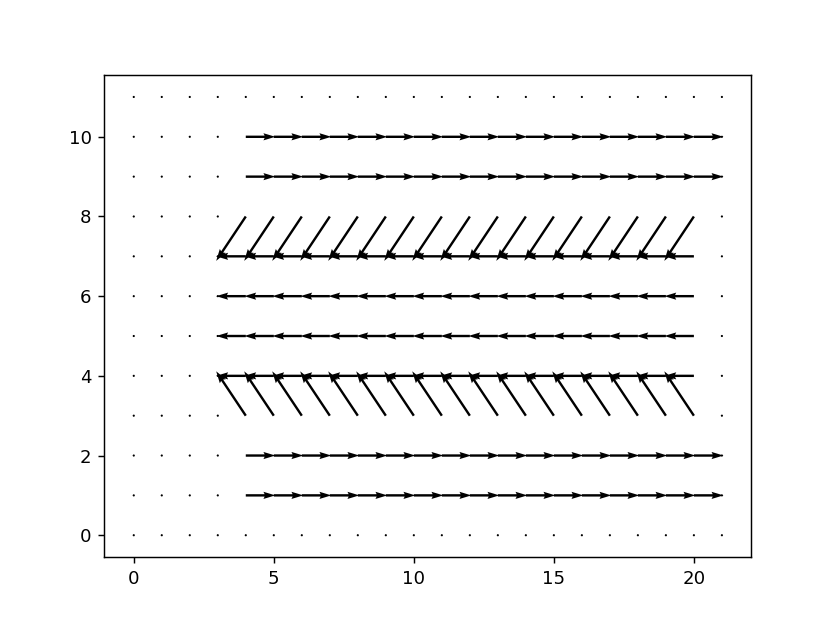

In [31]:
# (left-right),(down-up)

P_flux = np.array([P_out[:,:,3]-P_out[:,:,2],P_out[:,:,1]-P_out[:,:,0]])

plt.quiver(P_flux[1,:,:].T,P_flux[0,:,:].T)

In [21]:
P_flux[0,:,:].T.shape

(12, 22)

In [23]:
U.shape

(12, 22)